# **Experiment: Empirical NTK Drift and the Onset of the Lazy Regime**

## **Goal**

The goal of this experiment is to determine **when** and **whether** a finite-width
neural network enters the **lazy regime**, in which its training dynamics become
well-approximated by **kernel regression with a fixed Neural Tangent Kernel (NTK)**.

Specifically, we aim to answer the following questions:

1. **Does the empirical NTK on the training set stabilize after some training time?**
2. **If so, do the network predictions from that point onward match kernel regression
   with the frozen NTK?**
3. **Does the time at which the NTK stabilizes coincide with a slowdown or plateau in
   the training loss?**

Together, these provide a finite-width test of the lazy-training hypothesis.

---

## **Setup**

We consider a regression task defined on the **unit circle**.
The target function is a **Fourier mixture**
$$
f^*(\gamma) = \sum_k a_k \cos(k\gamma + \phi_k).
$$

- The evaluation grid is a **dense, uniform sampling** of the circle.
- The training set consists of **random points** sampled from the same circle.
- We train fully-connected ReLU MLPs of multiple widths using SGD.

---

## **What We Log**

At regular intervals (every `eval_every` steps), we record **NTK snapshots** and
associated training quantities.

### **1. Training-set NTK**

$$
K_{\text{train,train}}(t) \in \mathbb{R}^{M_{\text{train}} \times M_{\text{train}}}.
$$

This kernel governs the linearized training dynamics on the training set.
We use it to quantify kernel drift.

For visualization, we compute the **normalized cumulative drift**
$$
\Delta_K(t) = \frac{\|K(t) - K(0)\|_F}{\|K(0)\|_F}.
$$

---

### **2. Eval–Train NTK**

This kernel is required to form kernel-regression predictions:
$$
K_{\text{eval,train}}(t) \in \mathbb{R}^{N_{\text{eval}} \times M_{\text{train}}}.
$$

Given a frozen NTK at time $t^*$, the kernel-regression predictor is
$$
f_{\mathrm{KR}}(\gamma)
=
K_{\text{eval,train}}(t^*)
\bigl(K_{\text{train,train}}(t^*) + \lambda I\bigr)^{-1} y_{\text{train}}.
$$

---

### **3. Model Predictions**

At each snapshot, we record the network predictions
$f_{\text{net}}(\gamma,t)$ on the dense evaluation grid.

This allows direct comparison
$$
f_{\text{net}}(\gamma,t_{\text{final}})
\quad \text{vs} \quad
f_{\mathrm{KR}}(\gamma;K(t^*)).
$$

---

### **4. Snapshot Training Loss**

We record the training loss at snapshot steps:
$$
L(t)
=
\frac{1}{M_{\text{train}}}
\sum_{i=1}^{M_{\text{train}}}
\bigl(f_{\text{net}}(x_i,t)-y_i\bigr)^2.
$$

This allows alignment of optimization dynamics with kernel evolution.

---

## **Central Hypothesis**

If a network enters the **lazy regime**, we expect:

1. **NTK stabilization**:  
   The *incremental* change of the empirical NTK becomes negligible after some
   time $t_{\text{freeze}}$, even if the cumulative drift $\Delta_K(t)$ continues
   to grow slowly.

2. **Kernel-regression tracking**:  
   For $t > t_{\text{freeze}}$,
   $$
   f_{\text{net}}(\gamma,t)
   \approx
   f_{\mathrm{KR}}(\gamma;K(t_{\text{freeze}})).
   $$

3. **Loss slowdown**:  
   The NTK freeze time often coincides with a slowdown or plateau in the training
   loss.

---

## **Width Sweep**

We repeat the experiment for several widths
$$
W \in \{100,512,1024,2048,10000\},
$$
across multiple random seeds.

This allows us to study:
- how NTK drift scales with width,
- whether wider networks stabilize their NTK earlier,
- how finite-width deviations behave relative to kernel regression.

---

## **Saved Artifacts**

For each width and seed, we save:
- $K_{\text{train,train}}(t)$ snapshots  
- $K_{\text{eval,train}}(t)$ snapshots  
- $f_{\text{net}}(\gamma,t)$ predictions  
- $(\text{seed},\text{step})$ metadata for each snapshot  
- training-loss snapshots  
- the dataset (train + eval + Fourier parameters)

These artifacts allow reconstruction of:
- cumulative and incremental NTK drift curves,
- kernel-regression predictors,
- comparisons between GD and KR,
- identification of NTK freeze times.

---

## **Analysis Outline**

### **1. NTK Drift Curves**

We visualize cumulative drift
$$
\rho(t)=\frac{\|K(t)-K(0)\|_F}{\|K(0)\|_F},
$$
and detect NTK freezing using the **incremental kernel motion**
$\delta_K(t;\Delta)=\|K(t)-K(t-\Delta)\|_F / \|K(t-\Delta)\|_F$.

---

### **2. Kernel Regression at Freeze Time**

At the detected freeze time $t_{\text{freeze}}$, we solve
$$
\alpha
=
\bigl(K_{\text{train,train}}(t_{\text{freeze}})+\lambda I\bigr)^{-1}y_{\text{train}},
$$
and compute
$$
f_{\mathrm{KR}}
=
K_{\text{eval,train}}(t_{\text{freeze}})\,\alpha.
$$

We compare this predictor to the final network output.

---

### **3. Loss vs NTK Stabilization**

We plot:
- snapshot loss $L(t)$  
- cumulative NTK drift $\rho(t)$  

to assess whether NTK stabilization aligns with optimization slowdown.

---

## **Outcome**

If wide networks quickly stabilize their NTK and their predictions match kernel
regression thereafter, this provides empirical evidence for **lazy training**.

If narrower networks exhibit persistent incremental NTK drift, this indicates
ongoing **feature learning** and deviations from kernel-regression behavior.


In [1]:
import os, sys
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
print("Project root added to sys.path:", ROOT)

from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
import jax.numpy as jnp
from utils.artifacts_io import latest_run_dir, load_manifest, npz
from notebooks.utils_plotting import aggregate_over_seeds

Project root added to sys.path: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments


In [2]:
from dataclasses import dataclass

@dataclass
class PlotCfg:
    q_low: int = 10
    q_high: int = 90
    dpi: int = 300

@dataclass
class FreezeCfg:
    # old plateau detector (cumulative drift slope)
    delta_plateau: int = 2
    frac_plateau: float = 0.01
    k_plateau: int = 3

    # new incremental detector
    delta_inc: int = 1
    normalize_inc: str = "prev"   # "prev" recommended
    frac_inc: float = 0.01
    k_inc: int = 3
    warmup: int = 1

PLOT = PlotCfg()
FREEZE = FreezeCfg()

BASE = "../results"

EXPS = {
    "low":  "ntk_kernel_drift",
    "mid":  "ntk_kernel_drift_large_widths",
    "high": "ntk_kernel_drift_10000_more_steps",
}

WIDTHS = {
    "low":  [100, 512],
    "mid":  [1024, 2048, 10000],
    "high": [10000],
}

#### 0) Run registry (latest run dirs + manifests)
 
We keep all run paths + manifests in one place so the rest of the notebook
does not repeatedly reload them.


In [ ]:
RUNS = {k: latest_run_dir(BASE, exp) for k, exp in EXPS.items()}
MANS = {k: load_manifest(RUNS[k]) for k in RUNS}

# sanity print
for k in RUNS:
    print(f"{k:>4}: {RUNS[k]}")
    print(f"      widths in manifest: {MANS[k]['meta']['widths']}")

 low: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments/results/ntk_kernel_drift/20251121-143053-ef00d43a
      widths in manifest: [100, 512, 1024, 2048, 10000]
 mid: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments/results/ntk_kernel_drift_large_widths/20251124-105831-53d9a2d8
      widths in manifest: [1024, 2048, 10000]
high: /Users/shreyas/Documents/msc-cs/msc-thesis/code/ntk-experiments/results/ntk_kernel_drift_10000_more_steps/20251124-173524-4aab0fad
      widths in manifest: [10000]


#### 1) Plot styling helpers

In [10]:
width_colors = {
    100:  "#1f77b4",
    512:  "#ff7f0e",
    1024: "#2ca02c",
    2048: "#d62728",
    10000:"#9467bd",
}

#### 2) Core metric: cumulative drift ΔK(t) from initialization (for visualization)

Returns mean and percentile bands across seeds.

In [4]:
def kernel_drift_over_seeds(run_dir, man, width, q_low=10, q_high=90, normalize=True):
    block = npz(run_dir, man["runs"][str(width)])
    K_all = block["K_train_train"]      # (T_snap, M, M)
    meta  = block["kernel_meta"]        # (T_snap, 2): (seed, step)

    seeds = np.unique(meta[:, 0]).astype(int)
    steps_unique = np.sort(np.unique(meta[:, 1]).astype(int))

    # collect K(0) per seed
    K0 = {}
    K0_norm = {}
    for s in seeds:
        mask0 = (meta[:, 0] == s) & (meta[:, 1] == 0)
        assert mask0.sum() == 1, f"Expected exactly one t=0 snapshot for seed {s}"
        K0_s = K_all[mask0][0]
        K0[s] = K0_s
        K0_norm[s] = np.linalg.norm(K0_s)

    drift_mean, drift_lo, drift_hi = [], [], []

    for step in steps_unique:
        idxs = np.where(meta[:, 1] == step)[0]

        drifts = []
        for idx in idxs:
            s = int(meta[idx, 0])
            d = np.linalg.norm(K_all[idx] - K0[s])
            if normalize:
                d = d / K0_norm[s]
            drifts.append(d)

        drifts = np.asarray(drifts)
        drift_mean.append(drifts.mean())
        lo, hi = np.percentile(drifts, [q_low, q_high])
        drift_lo.append(lo)
        drift_hi.append(hi)

    return steps_unique, np.asarray(drift_mean), np.asarray(drift_lo), np.asarray(drift_hi)

#### 3) Core metric: incremental motion δK(t;Δ) between snapshots (for freeze detection)
 
This is robust to “rotation on a level set” effects.


In [5]:
def incremental_kernel_drift_over_seeds(
    run_dir, man, width,
    delta=1,
    q_low=10, q_high=90,
    normalize="prev",   # {"prev","init",None}
):
    block = npz(run_dir, man["runs"][str(width)])
    K_all = block["K_train_train"]
    meta  = block["kernel_meta"]        # (seed, step)

    seeds = np.unique(meta[:, 0]).astype(int)
    steps_unique = np.sort(np.unique(meta[:, 1]).astype(int))

    # per-seed ordered map
    per_seed = {}
    for s in seeds:
        mask = (meta[:, 0] == s)
        seed_steps = meta[mask, 1].astype(int)
        seed_idxs  = np.where(mask)[0]
        order = np.argsort(seed_steps)
        per_seed[s] = {"steps": seed_steps[order], "idxs": seed_idxs[order]}

    # init norms if requested
    K0_norm = {}
    if normalize == "init":
        for s in seeds:
            steps_s = per_seed[s]["steps"]
            idxs_s  = per_seed[s]["idxs"]
            j0 = np.where(steps_s == 0)[0]
            assert len(j0) == 1, f"Expected exactly one t=0 snapshot for seed {s}"
            K0 = K_all[idxs_s[j0[0]]]
            K0_norm[s] = np.linalg.norm(K0)

    drift_mean, drift_lo, drift_hi = [], [], []

    for i, step in enumerate(steps_unique):
        if i < delta:
            drift_mean.append(np.nan); drift_lo.append(np.nan); drift_hi.append(np.nan)
            continue

        step_prev = steps_unique[i - delta]
        drifts = []

        for s in seeds:
            steps_s = per_seed[s]["steps"]
            idxs_s  = per_seed[s]["idxs"]

            if (step not in steps_s) or (step_prev not in steps_s):
                continue

            idx_t  = idxs_s[np.where(steps_s == step)[0][0]]
            idx_tm = idxs_s[np.where(steps_s == step_prev)[0][0]]

            K_t  = K_all[idx_t]
            K_tm = K_all[idx_tm]

            d = np.linalg.norm(K_t - K_tm)

            if normalize == "prev":
                denom = np.linalg.norm(K_tm)
                if denom > 0:
                    d = d / denom
            elif normalize == "init":
                denom = K0_norm[s]
                if denom > 0:
                    d = d / denom

            drifts.append(d)

        drifts = np.asarray(drifts)
        drift_mean.append(drifts.mean())
        lo, hi = np.percentile(drifts, [q_low, q_high])
        drift_lo.append(lo)
        drift_hi.append(hi)

    return steps_unique, np.asarray(drift_mean), np.asarray(drift_lo), np.asarray(drift_hi)

#### 4) Freeze detectors (old vs new)

In [6]:
def find_freeze_step_plateau(
    steps, d_mean,
    delta=2,
    frac=0.01,
    min_consecutive=3,
):
    steps = np.asarray(steps)
    d_mean = np.asarray(d_mean)
    T = len(steps)
    if T <= delta + 1:
        return None

    dt0 = steps[delta] - steps[0]
    if dt0 == 0:
        return None
    s0 = (d_mean[delta] - d_mean[0]) / dt0
    s0_abs = abs(s0)
    if s0_abs == 0:
        return int(steps[0])

    thresh = frac * s0_abs
    consec = 0

    for i in range(delta, T):
        dt = steps[i] - steps[i - delta]
        if dt <= 0:
            continue
        s = (d_mean[i] - d_mean[i - delta]) / dt

        if abs(s) < thresh:
            consec += 1
        else:
            consec = 0

        if consec >= min_consecutive:
            return int(steps[i])

    return None


def find_freeze_step_incremental(
    steps, inc_mean,
    frac=0.01,
    min_consecutive=3,
    warmup=1,
):
    steps = np.asarray(steps)
    inc_mean = np.asarray(inc_mean)

    finite = np.isfinite(inc_mean)
    idxs = np.where(finite)[0]
    if len(idxs) == 0:
        return None

    start = idxs[0] + warmup
    end = min(start + 3, len(inc_mean))
    base_vals = inc_mean[start:end]
    base_vals = base_vals[np.isfinite(base_vals)]

    baseline = np.median(base_vals) if len(base_vals) else inc_mean[idxs[0]]

    if baseline == 0 or not np.isfinite(baseline):
        return int(steps[idxs[0]])

    thresh = frac * baseline
    consec = 0

    for i in idxs:
        if inc_mean[i] < thresh:
            consec += 1
        else:
            consec = 0

        if consec >= min_consecutive:
            return int(steps[i])

    return None


### **Determining the NTK Freeze Time**

To study when the empirical NTK effectively stops changing during training, we
consider two complementary notions of kernel drift.

---

#### **Cumulative drift from initialization**

We first track the **normalized cumulative kernel drift**
$$
\Delta_K(t)
=
\frac{\|K(t) - K(0)\|_F}{\|K(0)\|_F}.
$$
This quantity measures the total deviation of the kernel from its initial value
and provides a convenient global summary of how much the NTK evolves over training.

A commonly used heuristic for detecting NTK stabilization is based on the
**slope** of this drift curve. We estimate a finite-difference slope
$$
s(t)
=
\frac{\Delta_K(t) - \Delta_K(t - \Delta)}
     {\mathrm{step}(t) - \mathrm{step}(t - \Delta)}.
$$
The corresponding **plateau-based freeze time** is defined as the earliest
training step $t_{\text{freeze}}$ for which
$$
|s(t)| < \varepsilon\,|s(0)|
$$
and this condition holds for $k$ consecutive snapshot intervals.

Typical choices are:
- look-back window: $\Delta = 2$ snapshots  
- slope fraction threshold: $\varepsilon = 0.01$ (1%)  
- consecutive confirmations: $k = 3$

This criterion detects when the **rate of increase** of $\Delta_K(t)$ becomes
negligible and is useful for visualizing when the cumulative drift curve flattens.

---

#### **Incremental kernel motion (corrected freeze criterion)**

However, cumulative drift alone is **not sufficient** to determine whether the
NTK has truly frozen. The quantity $\Delta_K(t)$ can plateau even if $K(t)$
continues to evolve—for example, if the kernel moves along a level set around
$K(0)$ (a “rotation” in kernel space).

To directly measure whether the kernel is still changing, we instead track the
**incremental motion** of the NTK between consecutive snapshots:
$$
\delta_K(t;\Delta)
=
\frac{\|K(t) - K(t-\Delta)\|_F}{\|K(t-\Delta)\|_F}.
$$
This quantity captures the *instantaneous step-to-step change* of the kernel and
vanishes only when the NTK itself becomes stationary.

We define the **incremental freeze time** $t_{\text{freeze}}$ as the earliest
snapshot step for which
$$
\delta_K(t;\Delta) < \varepsilon\,\delta_K(t_0;\Delta)
\quad \text{for } k \text{ consecutive snapshot steps},
$$
where $t_0$ is an early reference time (e.g., the first valid snapshot after
warm-up).

In practice, we use:
- snapshot lag: $\Delta = 1$ snapshot  
- threshold: $\varepsilon = 0.01$ (1% of early incremental drift)  
- consecutive confirmations: $k = 3$

---

#### **Summary**

In our analysis, we:
- **plot $\Delta_K(t)$** to visualize the overall magnitude of NTK drift,
- **report both freeze times** for comparison,
- **use the incremental criterion based on $\delta_K(t;\Delta)$** as the primary
  indicator of NTK freezing, since it correctly detects when the kernel itself
  stops evolving.

This distinction is important for reliably identifying entry into the
**lazy (kernel) training regime**.


In [7]:
FREEZE_PLATEAU = {}
FREEZE_INC = {}

for group, widths in WIDTHS.items():
    run_dir = RUNS[group]
    man = MANS[group]

    FREEZE_PLATEAU[group] = {}
    FREEZE_INC[group] = {}

    for w in widths:
        # old
        steps, d_mean, *_ = kernel_drift_over_seeds(
            run_dir, man, w, q_low=PLOT.q_low, q_high=PLOT.q_high, normalize=True
        )
        f_old = find_freeze_step_plateau(
            steps, d_mean,
            delta=FREEZE.delta_plateau,
            frac=FREEZE.frac_plateau,
            min_consecutive=FREEZE.k_plateau,
        )

        # new
        steps2, inc_mean, *_ = incremental_kernel_drift_over_seeds(
            run_dir, man, w,
            delta=FREEZE.delta_inc,
            q_low=PLOT.q_low, q_high=PLOT.q_high,
            normalize=FREEZE.normalize_inc,
        )
        f_new = find_freeze_step_incremental(
            steps2, inc_mean,
            frac=FREEZE.frac_inc,
            min_consecutive=FREEZE.k_inc,
            warmup=FREEZE.warmup,
        )

        FREEZE_PLATEAU[group][w] = f_old
        FREEZE_INC[group][w] = f_new

        print(f"{group:>4}  w={w:5d}  old={f_old}  new={f_new}")

 low  w=  100  old=13000  new=None
 low  w=  512  old=51500  new=None
 mid  w= 1024  old=115000  new=None
 mid  w= 2048  old=310000  new=385000
 mid  w=10000  old=None  new=None
high  w=10000  old=None  new=None


#### 6) Drift plot (ΔK curves) + both freeze markers
 
- Solid curve: mean ΔK(t)
- Shaded band: percentile spread
- Dashed line: old freeze (plateau)
- Dotted line: new freeze (incremental)


In [8]:
def plot_kernel_drift_for_width(
    run_dir, man, widths,
    freeze_old=None,
    freeze_new=None,
    q_low=10, q_high=90,
    normalize=True,
    save_path=None,
):
    plt.figure(figsize=(8, 5))

    old_proxy = plt.Line2D([0],[0], color="k", linestyle="--", linewidth=1.5,
                           label="freeze (old: plateau vs init)")
    new_proxy = plt.Line2D([0],[0], color="k", linestyle=":", linewidth=1.8,
                           label="freeze (new: incremental motion)")

    for w in widths:
        steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(
            run_dir, man, w, q_low=q_low, q_high=q_high, normalize=normalize
        )
        color = width_colors.get(w, None)

        plt.plot(steps, d_mean, color=color, label=f"w={w}")
        plt.fill_between(steps, d_lo, d_hi, alpha=0.15, color=color)

        f_old = None if freeze_old is None else freeze_old.get(w, None)
        f_new = None if freeze_new is None else freeze_new.get(w, None)

        if f_old is not None:
            plt.axvline(f_old, color=color, linestyle="--", alpha=0.7)
            plt.text(f_old, np.nanmax(d_mean)*0.06, f"{f_old}",
                     rotation=90, va="bottom", ha="right",
                     fontsize=9, color=color, alpha=0.85)

        if f_new is not None:
            plt.axvline(f_new, color=color, linestyle=":", alpha=0.9, linewidth=1.8)
            plt.text(f_new, np.nanmax(d_mean)*0.30, f"{f_new}",
                     rotation=90, va="bottom", ha="right",
                     fontsize=9, color=color, alpha=0.95)

    plt.xlabel("Training step")
    plt.ylabel(r"Normalized NTK drift  $\|K_t - K_0\|_F / \|K_0\|_F$" if normalize
               else r"NTK drift  $\|K_t - K_0\|_F$")
    plt.title("NTK cumulative drift (ΔK) with freeze points")
    plt.grid(alpha=0.3)

    handles, labels = plt.gca().get_legend_handles_labels()
    if freeze_old is not None: handles.append(old_proxy); labels.append(old_proxy.get_label())
    if freeze_new is not None: handles.append(new_proxy); labels.append(new_proxy.get_label())
    plt.legend(handles, labels, fontsize=9)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=PLOT.dpi)
    plt.show()


=== low ===


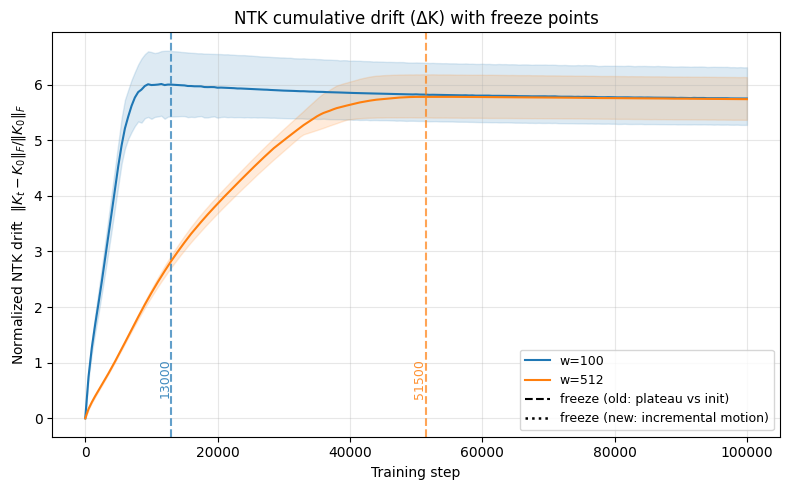


=== mid ===


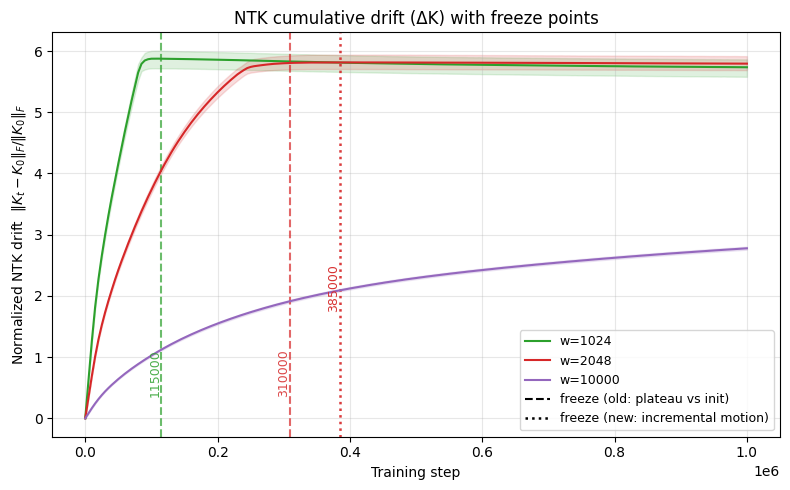


=== high ===


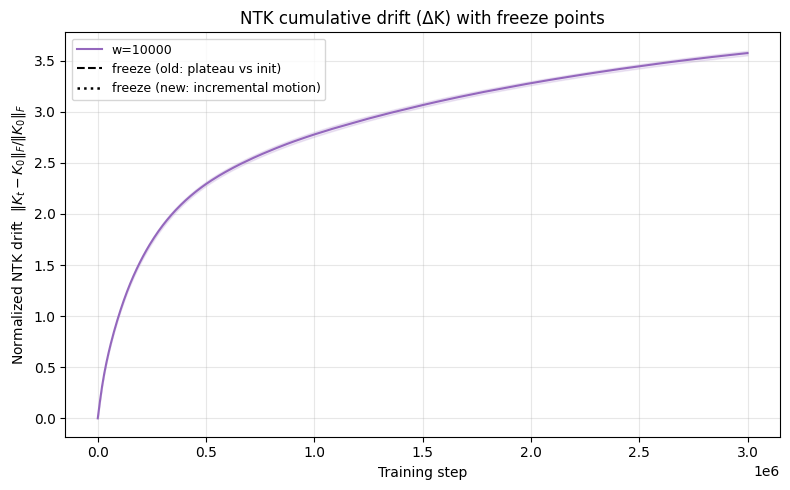

In [11]:
for group, widths in WIDTHS.items():
    print("\n===", group, "===")
    plot_kernel_drift_for_width(
        RUNS[group], MANS[group], widths,
        freeze_old=FREEZE_PLATEAU[group],
        freeze_new=FREEZE_INC[group],
        q_low=PLOT.q_low, q_high=PLOT.q_high,
        normalize=True,
        save_path=None,
    )

In [13]:
# %% [markdown]
# ## 8) Loss plots (use **new** freeze by default)

# %%
def loss_over_seeds(run_dir, man, width, q_low=10, q_high=90):
    block = npz(run_dir, man["runs"][str(width)])
    loss_meta   = block["loss_meta"]    # (T_snap, 2) = (seed, step)
    loss_values = block["loss_values"]  # (T_snap,)

    steps_unique = np.sort(np.unique(loss_meta[:, 1]).astype(int))

    loss_mean, loss_lo, loss_hi = [], [], []
    for step in steps_unique:
        vals = loss_values[loss_meta[:, 1] == step]
        loss_mean.append(vals.mean())
        lo, hi = np.percentile(vals, [q_low, q_high])
        loss_lo.append(lo); loss_hi.append(hi)

    return np.asarray(steps_unique), np.asarray(loss_mean), np.asarray(loss_lo), np.asarray(loss_hi)


def plot_loss_for_widths(run_dir, man, widths, freeze_dict=None,
                         q_low=10, q_high=90, ymin=None, ymax=None, save_path=None):
    plt.figure(figsize=(8, 5))

    for w in widths:
        steps, mu, lo, hi = loss_over_seeds(run_dir, man, w, q_low=q_low, q_high=q_high)
        color = width_colors.get(w, None)

        plt.plot(steps, mu, color=color, label=f"w={w}")
        plt.fill_between(steps, lo, hi, alpha=0.15, color=color)

        if freeze_dict is not None:
            f = freeze_dict.get(w, None)
            if f is not None:
                plt.axvline(f, color=color, linestyle=":", alpha=0.9, linewidth=1.8)

    plt.xlabel("Training step")
    plt.ylabel("Training MSE loss")
    plt.title("Training loss vs steps")
    plt.grid(alpha=0.3)
    plt.legend()

    if ymin is not None or ymax is not None:
        plt.ylim(ymin, ymax)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=PLOT.dpi)
    plt.show()



=== low ===


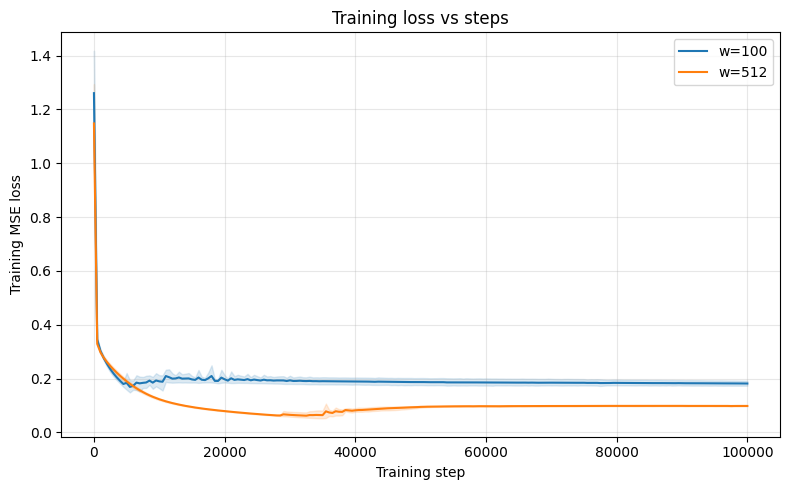


=== mid ===


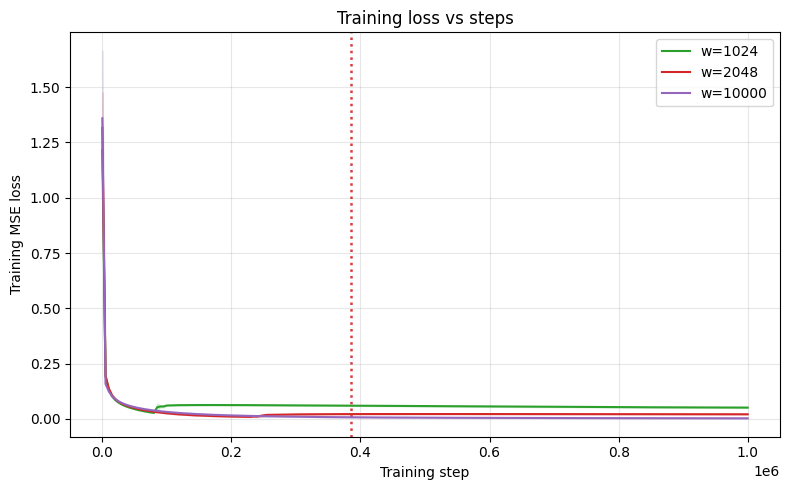


=== high ===


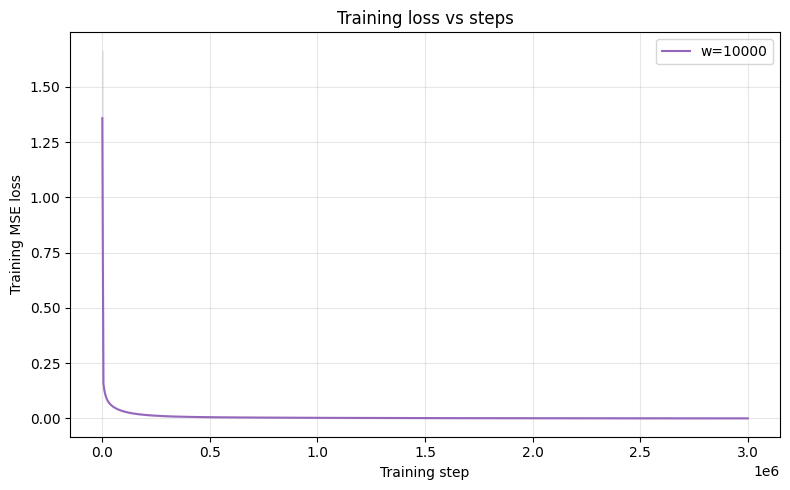

In [14]:
for group, widths in WIDTHS.items():
    print("\n===", group, "===")
    plot_loss_for_widths(
        RUNS[group], MANS[group], widths,
        freeze_dict=FREEZE_INC[group],   # <-- new criterion
        q_low=PLOT.q_low, q_high=PLOT.q_high,
        save_path=None,
    )

In [ ]:
# This is the only place where we create folders and write files.

# %%
SAVE = False  # flip to True only at the end

if SAVE:
    out_root = Path("plots")
    out_root.mkdir(exist_ok=True)

    # drift
    (out_root / "kernel_drift").mkdir(exist_ok=True)
    for group, widths in WIDTHS.items():
        plot_kernel_drift_for_width(
            RUNS[group], MANS[group], widths,
            freeze_old=FREEZE_PLATEAU[group],
            freeze_new=FREEZE_INC[group],
            q_low=PLOT.q_low, q_high=PLOT.q_high,
            normalize=True,
            save_path=(out_root / "kernel_drift" / f"kernel_drift_{group}.png"),
        )

    # loss
    (out_root / "loss_curves").mkdir(exist_ok=True)
    for group, widths in WIDTHS.items():
        plot_loss_for_widths(
            RUNS[group], MANS[group], widths,
            freeze_dict=FREEZE_INC[group],
            q_low=PLOT.q_low, q_high=PLOT.q_high,
            save_path=(out_root / "loss_curves" / f"loss_{group}.png"),
        )

    print("Saved plots under:", out_root.resolve())
else:
    print("SAVE=False (no files will be written).")

In [17]:
def eigenvalues_over_time(run_dir, man, width, k=5,
                          q_low=10, q_high=90):
    """
    Compute top-k eigenvalues over time from kernel matrices.

    Returns:
        steps_unique  : (T_steps,)
        eig_mean      : (T_steps, k)
        eig_lo        : (T_steps, k)
        eig_hi        : (T_steps, k)
    """
    block = npz(run_dir, man["runs"][str(width)])
    K_all = block["K_train_train"]     # (T_snap, M, M)
    meta  = block["kernel_meta"]       # (T_snap, 2) = (seed, step)

    steps_unique = np.sort(np.unique(meta[:,1]))

    eig_mean = []
    eig_lo   = []
    eig_hi   = []

    for step in steps_unique:
        mask = (meta[:,1] == step)
        Ks = K_all[mask]   # (n_seeds, M, M)

        eigs_seed = []
        for K in Ks:
            # symmetric eigenvalues
            e = np.linalg.eigvalsh(K.squeeze())
            e_sorted = np.sort(e)[::-1]   # descending
            eigs_seed.append(e_sorted[:k])

        eigs_seed = np.array(eigs_seed)   # (n_seeds, k)

        mu = eigs_seed.mean(axis=0)
        lo, hi = np.percentile(eigs_seed, [q_low, q_high], axis=0)

        eig_mean.append(mu)
        eig_lo.append(lo)
        eig_hi.append(hi)

    return (
        np.array(steps_unique),
        np.array(eig_mean),
        np.array(eig_lo),
        np.array(eig_hi)
    )

def plot_topk_eigenvalues_for_width(run_dir, man, width,
                                    k=5, q_low=10, q_high=90, save_path=None):
    steps, eig_mean, eig_lo, eig_hi = eigenvalues_over_time(
        run_dir, man, width, k=k, q_low=q_low, q_high=q_high
    )

    plt.figure(figsize=(7,5))

    for i in range(k):
        plt.plot(steps, eig_mean[:,i], label=rf"$\lambda_{i+1}$")
        plt.fill_between(steps, eig_lo[:,i], eig_hi[:,i], alpha=0.2)

    plt.xlabel("Training step")
    plt.ylabel(r"Eigenvalue of $K_train_train(t)$")
    plt.title(f"Top-{k} NTK eigenvalues over training - width={width}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()



=== low ===


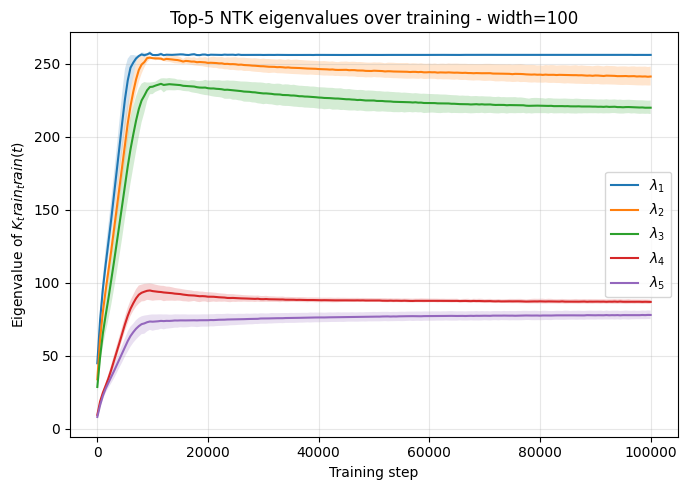

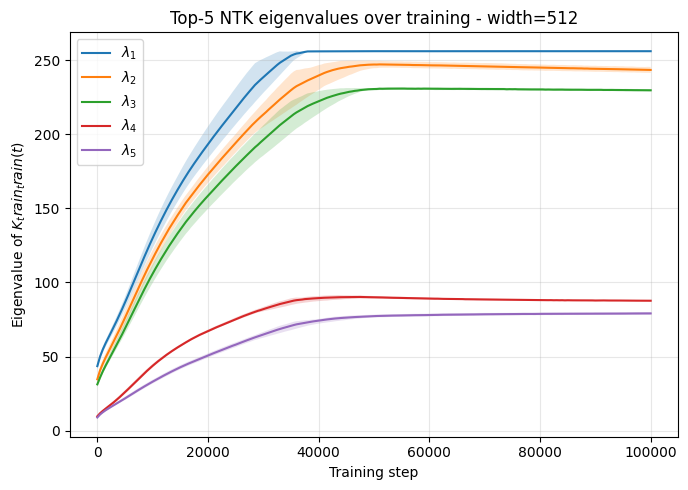


=== mid ===


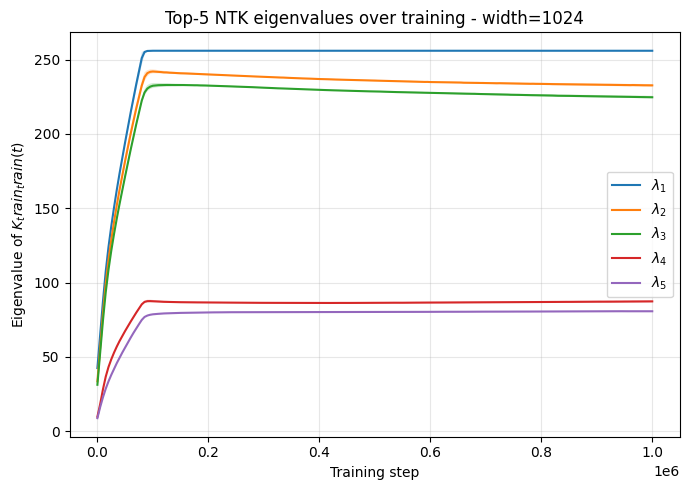

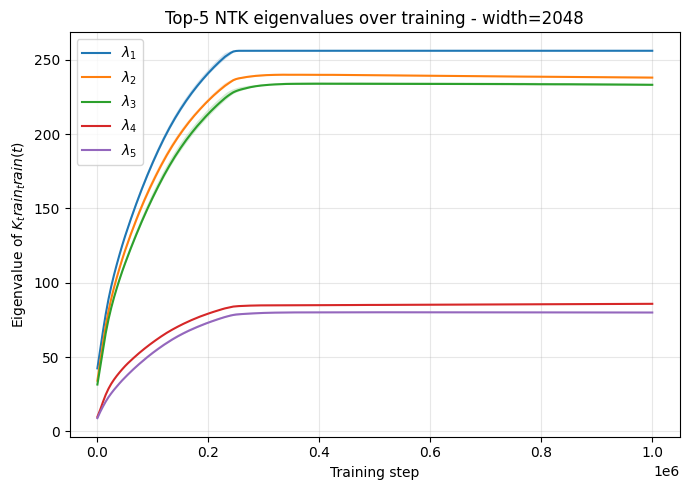

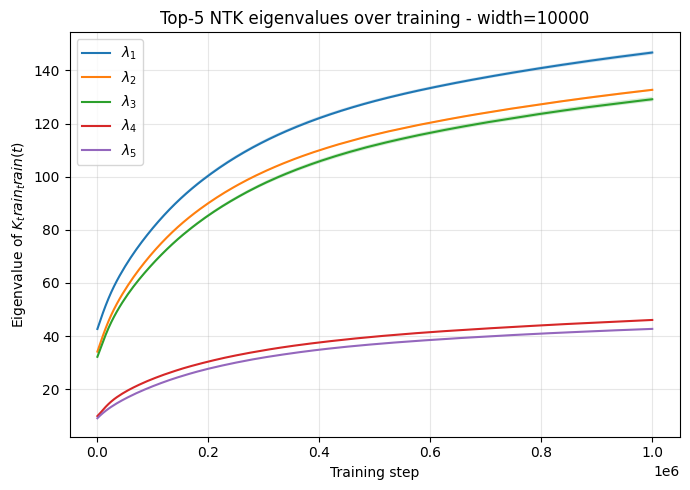


=== high ===


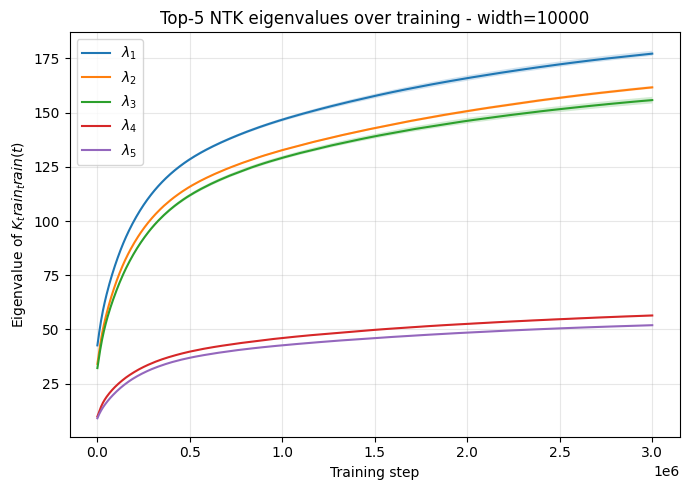

In [18]:
for group, widths in WIDTHS.items():
    print("\n===", group, "===")
    for w in widths:
        plot_topk_eigenvalues_for_width(
            RUNS[group], MANS[group], w,
            k=5, q_low=PLOT.q_low, q_high=PLOT.q_high,
            save_path=None,
        )

In [19]:
def get_preds_for_step(block, step):
    """
    Returns:
        seeds: array of seed IDs
        preds_matrix: (n_seeds, n_eval) predictions for that step
                      nearest snapshot if exact step not present.
    """
    meta  = block["preds_meta"]
    preds = block["preds"]

    seeds = np.unique(meta[:,0])
    n_eval = preds.shape[1]

    out = []

    for s in seeds:
        seed_mask  = (meta[:,0] == s)
        seed_steps = meta[seed_mask, 1]
        seed_idxs  = np.where(seed_mask)[0]

        # nearest snapshot if exact missing
        nearest_idx = seed_idxs[np.argmin(np.abs(seed_steps - step))]
        out.append(preds[nearest_idx])

    return seeds, np.array(out)

def plot_predictions_freeze_vs_final_spread(run_dir, man, width, freeze_step,
                                           q_low=10, q_high=90, save_path=None):
    """
    Plot mean prediction ± spread across seeds for:
        - freeze step
        - final step
        - difference between them
    """

    if freeze_step is None:
        print(f"[skip] width={width} has no freeze_step")
        return

    block = npz(run_dir, man["runs"][str(width)])

    # Load eval grid
    data_block = npz(run_dir, man["data_file"])
    gamma_eval = data_block["gamma_eval"]
    y_eval_true = data_block["y_eval_true"]

    # Get all seeds' predictions
    seeds, freeze_preds = get_preds_for_step(block, freeze_step)
    _,      final_preds = get_preds_for_step(block, np.max(block["preds_meta"][:,1]))

    # Compute statistics
    def agg(mat):
        mu = mat.mean(axis=0)
        lo = np.percentile(mat, q_low,  axis=0)
        hi = np.percentile(mat, q_high, axis=0)
        return mu, lo, hi

    mu_fz, lo_fz, hi_fz = agg(freeze_preds)
    mu_fn, lo_fn, hi_fn = agg(final_preds)

    diff_mat = final_preds - freeze_preds
    mu_df, lo_df, hi_df = agg(diff_mat)

    # Plot
    plt.figure(figsize=(10,5))

    plt.plot(gamma_eval, y_eval_true, color="gray", linewidth=2.0,
            label=r"$f^*(\gamma)$", alpha=0.7)

    # freeze predictions
    plt.plot(gamma_eval, mu_fz, label=f"w={width} (t={freeze_step})")
    plt.fill_between(gamma_eval, lo_fz, hi_fz, alpha=0.2)

    # final predictions
    plt.plot(gamma_eval, mu_fn, label=f"w={width} (t={np.max(block['preds_meta'][:,1])})")
    plt.fill_between(gamma_eval, lo_fn, hi_fn, alpha=0.2)

    # difference
    # plt.plot(gamma_eval, mu_df, label="difference", alpha=0.7)
    # plt.fill_between(gamma_eval, lo_df, hi_df, alpha=0.15)

    plt.title(f"Predictions (mean ± spread): width={width}")
    plt.xlabel("γ")
    plt.ylabel("Prediction")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_all_freeze_vs_final_spread(run_dir, man, freeze_dict, widths=None, save_path=None):
    for width in widths or freeze_dict.keys():
        freeze_step = freeze_dict.get(width, None)
        if freeze_step is None:
            continue
        print(f"\n=== width={width}, freeze_step={freeze_step} ===")
        if save_path:
            save_path = Path(save_path).with_name(f"predictions_w{width}_freeze.png") 
        plot_predictions_freeze_vs_final_spread(run_dir, man, width, freeze_step, save_path=save_path)



=== low ===

=== mid ===

=== width=2048, freeze_step=385000 ===


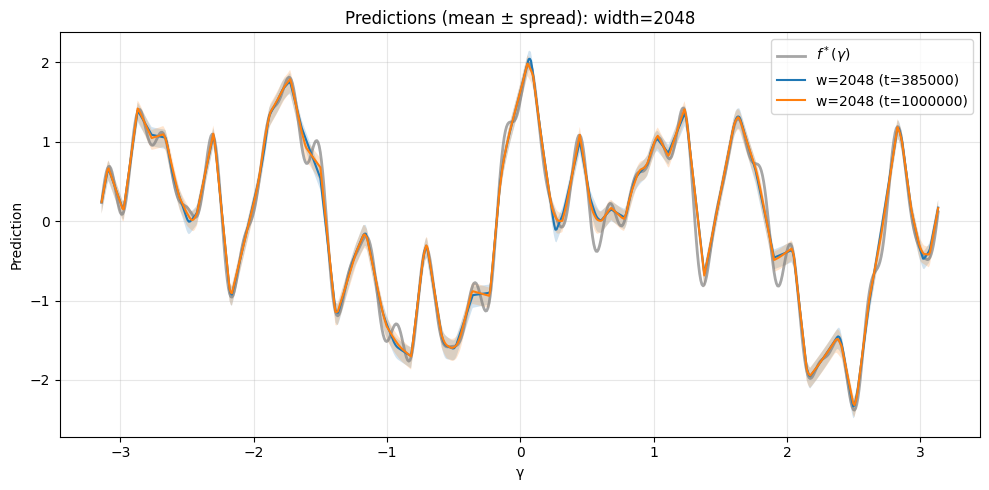


=== high ===


In [20]:
for group, widths in WIDTHS.items():
    print("\n===", group, "===")
    RUN = RUNS[group]   
    plot_all_freeze_vs_final_spread(RUN, MANS[group], FREEZE_INC[group], widths)

In [21]:
def get_kernel_matrices_for_step(block, step):
    """
    Returns:
      seeds: array of seeds
      Ks_train: list of (M_train x M_train) matrices, one per seed
      Ks_eval:  list of (n_eval x M_train) matrices, one per seed
    """
    meta = block["kernel_meta"]     # (T_snap, 2) = (seed, step)
    Ktt_all = block["K_train_train"]
    Ket_all = block["K_eval_train"]

    seeds = np.unique(meta[:,0])

    Ks_train = []
    Ks_eval  = []

    for s in seeds:
        mask = (meta[:,0] == s)
        seed_steps = meta[mask,1]
        seed_idxs  = np.where(mask)[0]

        # nearest available snapshot
        nearest = seed_idxs[np.argmin(np.abs(seed_steps - step))]

        Ks_train.append(Ktt_all[nearest].squeeze())
        Ks_eval.append(Ket_all[nearest].squeeze())

    return seeds, Ks_train, Ks_eval


In [22]:
def check_ntk_condition(K_list, seeds):
    conditioning_dict = {}
    for K, s in zip(K_list, seeds):
        conditioning = {}
        K = np.squeeze(K)
        vals = np.linalg.eigvalsh(K)
        lam_min, lam_max = vals.min(), vals.max()
        cond = np.linalg.cond(K)
        asym = np.linalg.norm(K - K.T)

        conditioning["min_eig"] = lam_min
        conditioning["max_eig"] = lam_max
        conditioning["cond"]    = cond
        conditioning["asym"]    = asym

        conditioning_dict[int(s)] = conditioning

    return conditioning_dict


In [30]:
conds = {}
for group, widths in WIDTHS.items():
    print("\n===", group, "===")
    run = RUNS[group]
    for width in widths:
        if FREEZE_INC[group][width] is None:
            print(f"[skip] width={width} has no freeze step")
            continue

        block = npz(run, MANS[group]["runs"][str(width)])
        seeds, Ktts, Kets = get_kernel_matrices_for_step(block, FREEZE_INC[group][width])
        conds[width] = check_ntk_condition(Ktts, seeds)

        print(f"\n--- width={width} ---")
        for s in seeds:
            c = conds[width][int(s)]
            print(f"seed={int(s):3d}  min_eig={c['min_eig']:.4e}  max_eig={c['max_eig']:.4e}  cond={c['cond']:.4e}  asym={c['asym']:.4e}")


=== low ===
[skip] width=100 has no freeze step
[skip] width=512 has no freeze step

=== mid ===
[skip] width=1024 has no freeze step

--- width=2048 ---
seed=  0  min_eig=-2.4770e-06  max_eig=2.5601e+02  cond=1.5863e+11  asym=0.0000e+00
seed=  1  min_eig=-2.0993e-06  max_eig=2.5600e+02  cond=1.1329e+10  asym=0.0000e+00
seed=  2  min_eig=-1.9735e-06  max_eig=2.5600e+02  cond=5.6432e+10  asym=0.0000e+00
seed=  3  min_eig=-2.3042e-06  max_eig=2.5600e+02  cond=1.3454e+11  asym=0.0000e+00
seed=  4  min_eig=-2.0640e-06  max_eig=2.5601e+02  cond=1.5982e+10  asym=0.0000e+00
[skip] width=10000 has no freeze step

=== high ===
[skip] width=10000 has no freeze step


In [31]:
def kernel_regression(K_train, K_eval, y_train, reg=1e-6):
    M = K_train.shape[0]
    A = K_train + reg * np.eye(M)
    alpha = np.linalg.solve(A, y_train)
    return K_eval @ alpha

def aggregate_kernel_predictions(Ks_train, Ks_eval, y_train, reg=1e-6,
                                 q_low=10, q_high=90):
    preds = []

    for Ktt, Ket in zip(Ks_train, Ks_eval):
        f_kr = kernel_regression(Ktt, Ket, y_train, reg=reg)
        preds.append(f_kr)

    preds = np.array(preds)   # (n_seeds, n_eval)

    mu = preds.mean(axis=0)
    lo = np.percentile(preds, q_low,  axis=0)
    hi = np.percentile(preds, q_high, axis=0)

    return mu, lo, hi, preds

def plot_kernel_regression_for_width(run_dir, man, width, kr_step,
                                     q_low=10, q_high=90,
                                     reg=1e-6,
                                     plot_network_final=True, save_path=None):

    block = npz(run_dir, man["runs"][str(width)])
    data_block = npz(run_dir, man["data_file"])

    gamma_eval  = data_block["gamma_eval"]
    y_eval_true = data_block["y_eval_true"]
    y_train     = block["y_train"]

    # --- extract NTK matrices for each seed at step kr_step
    seeds, Ks_train, Ks_eval = get_kernel_matrices_for_step(block, kr_step)

    # --- kernel regression
    mu, lo, hi, all_preds = aggregate_kernel_predictions(
        Ks_train, Ks_eval, y_train, reg=reg,
        q_low=q_low, q_high=q_high
    )

    # --- plot
    plt.figure(figsize=(10,5))

    # target
    plt.plot(gamma_eval, y_eval_true, color="gray",
             linewidth=2.0, label=r"$f^*(\gamma)$", alpha=0.9)

    # kernel regression mean
    plt.plot(gamma_eval, mu,
             label=fr"$f_{{KR}}(t={kr_step})$(regularized $\lambda$={reg})",)
    plt.fill_between(gamma_eval, lo, hi, alpha=0.2)

    # network final prediction (optional)
    if plot_network_final:
        final_step = int(np.max(block["preds_meta"][:,1]))
        _, final_preds = get_preds_for_step(block, final_step)
        mu_fn = final_preds.mean(axis=0)
        lo_fn = np.percentile(final_preds, q_low,  axis=0)
        hi_fn = np.percentile(final_preds, q_high, axis=0)
        plt.plot(gamma_eval, mu_fn,
                 label=fr"$f_{{{width}}}(t={final_step})$",
                 linestyle="--")
        plt.fill_between(gamma_eval, lo_fn, hi_fn, alpha=0.1)

    plt.title(f"Kernel Regression at t={kr_step} (width={width})")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Prediction")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_kernel_regression_all(run_dir, man, kr_dict,
                               reg=1e-6, q_low=10, q_high=90, save_path=None):
    for width, kr_step in kr_dict.items():
        if kr_step is None:
            print(f"Skipping width {width}: no kr_step")
            continue
        print(f"\n=== width={width}, KR step={kr_step} ===")
        if save_path:
            save_path = Path(save_path).with_name(f"kernel_regression_w{width}_step.png")
        plot_kernel_regression_for_width(
            run_dir, man, width, kr_step,
            reg=reg, q_low=q_low, q_high=q_high, save_path=save_path
        )

In [32]:
KR_STEPS = {
    group: {w: FREEZE_INC[group].get(w, None) for w in widths}
    for group, widths in WIDTHS.items()
}
KR_STEPS

{'low': {100: None, 512: None},
 'mid': {1024: None, 2048: 385000, 10000: None},
 'high': {10000: None}}


=== low ===
Skipping width 100: no kr_step
Skipping width 512: no kr_step

=== mid ===
Skipping width 1024: no kr_step

=== width=2048, KR step=385000 ===


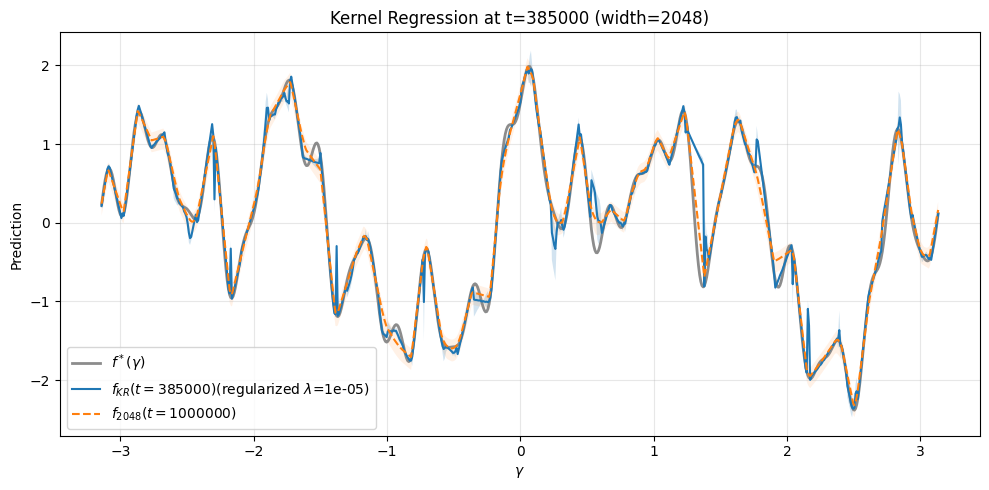

Skipping width 10000: no kr_step

=== high ===
Skipping width 10000: no kr_step


In [33]:
for group, widths in WIDTHS.items():
    print("\n===", group, "===")
    plot_kernel_regression_all(
        RUNS[group], MANS[group],
        kr_dict=KR_STEPS[group],
        reg=1e-5,
        q_low=PLOT.q_low, q_high=PLOT.q_high,
        save_path=None,
    )

In [34]:
def plot_error_vs_width(run_dir, man, freeze_dict, reg=1e-3,
                        q_low=10, q_high=90, save_path=None):
    """
    Plot:
        mean L2 error vs width
        ± percentile spread across seeds
    For:
        - Kernel Regression at freeze step
        - Final Network predictions
    """
    data_block = npz(run_dir, man["data_file"])
    y_eval_true = data_block["y_eval_true"]

    widths = []
    kr_means = []
    kr_los = []
    kr_his = []
    nn_means = []
    nn_los = []
    nn_his = []

    for width, freeze_step in freeze_dict.items():
        if freeze_step is None:
            continue

        block = npz(run_dir, man["runs"][str(width)])
        y_train = block["y_train"]

        # KR predictions
        seeds, Ktts, Kets = get_kernel_matrices_for_step(block, freeze_step)
        kr_preds = []
        for Ktt, Ket in zip(Ktts, Kets):
            pred = kernel_regression(Ktt, Ket, y_train, reg=reg)
            kr_preds.append(pred)
        kr_preds = np.array(kr_preds)  # (n_seeds, n_eval)

        # Final NN predictions
        final_step = int(np.max(block["preds_meta"][:,1]))
        _, final_preds = get_preds_for_step(block, final_step)
        final_preds = np.array(final_preds)

        # Errors
        err_kr = np.linalg.norm(kr_preds - y_eval_true, axis=1)
        err_nn = np.linalg.norm(final_preds - y_eval_true, axis=1)

        # Aggregate
        widths.append(width)

        kr_means.append(err_kr.mean())
        kr_los.append(np.percentile(err_kr, q_low))
        kr_his.append(np.percentile(err_kr, q_high))

        nn_means.append(err_nn.mean())
        nn_los.append(np.percentile(err_nn, q_low))
        nn_his.append(np.percentile(err_nn, q_high))

    widths = np.array(widths)

    # ---- Plot ----
    plt.figure(figsize=(7,5))

    # KR curve + spread
    plt.plot(widths, kr_means, "o-", label="Kernel Regression")
    plt.fill_between(widths, kr_los, kr_his, alpha=0.25)

    # NN curve + spread
    plt.plot(widths, nn_means, "o-", label="Final Network")
    plt.fill_between(widths, nn_los, nn_his, alpha=0.25)

    plt.xscale("log")
    plt.xlabel("Width")
    plt.ylabel(r"$\|f(\gamma) - f^*(\gamma)\|_2$")
    plt.title("Error vs Width (mean ± spread across seeds)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()


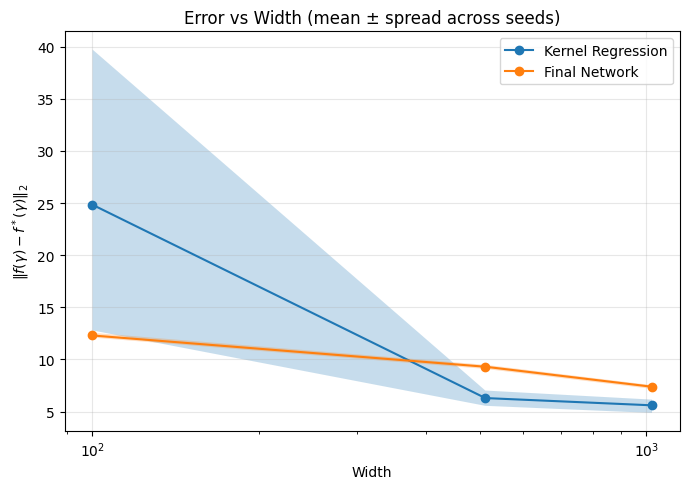

In [ ]:
plot_error_vs_width(RUN, man, freeze_steps, reg=1e-5)

## Training longer for higher widths

In [50]:
BASE = "../results"; EXP = "ntk_kernel_drift_large_widths"
RUN = latest_run_dir(BASE, EXP)

man = load_manifest(RUN)
man

{'data_file': 'data_fourier.npz',
 'runs': {'1024': 'runs/width_1024.npz',
  '2048': 'runs/width_2048.npz',
  '10000': 'runs/width_10000.npz'},
 'meta': {'widths': [1024, 2048, 10000],
  'seeds': 5,
  'steps': 1000000,
  'lr': 1.0,
  'eval_every': 5000,
  'depth_hidden': 1,
  'M_train': 256,
  'n_eval': 720,
  'noise_std': 0.02},
 'runtime_sec': 10149.67}

In [ ]:
widths_all = man["meta"]["widths"]
freeze_steps = {}
for width in widths_all:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN, man, width, normalize=True)
    freeze_step = find_freeze_step_plateau(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step

print(freeze_steps)

Width 1024 freeze step: 115000
Width 2048 freeze step: 310000
Width 10000 freeze step: None
{1024: 115000, 2048: 310000, 10000: None}


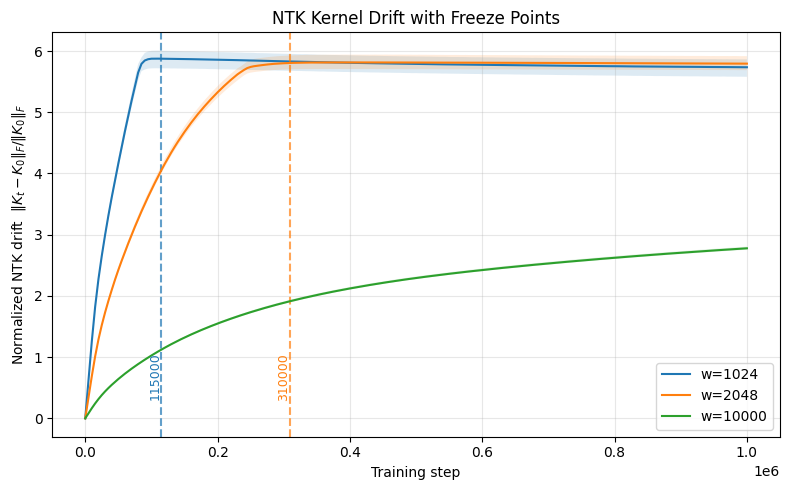

In [52]:
plot_kernel_drift_for_width(RUN, man, widths_all)

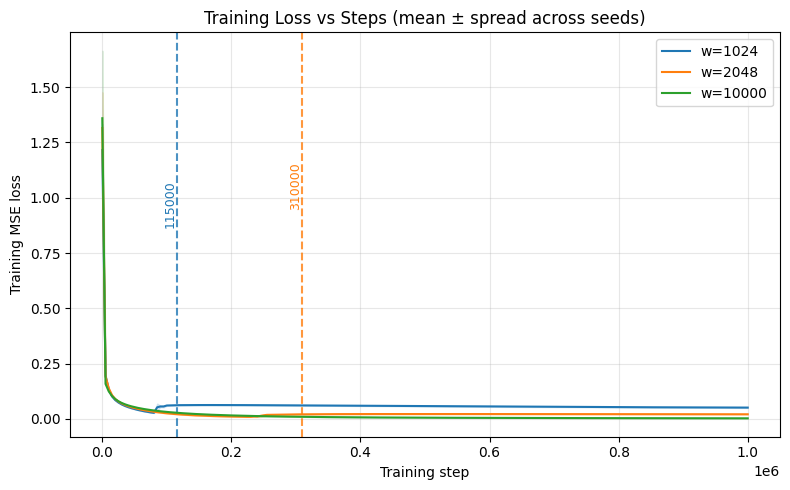

In [53]:
plot_loss_for_widths(RUN, man, widths_all, freeze_dict=freeze_steps)


=== width=1024, freeze_step=115000 ===


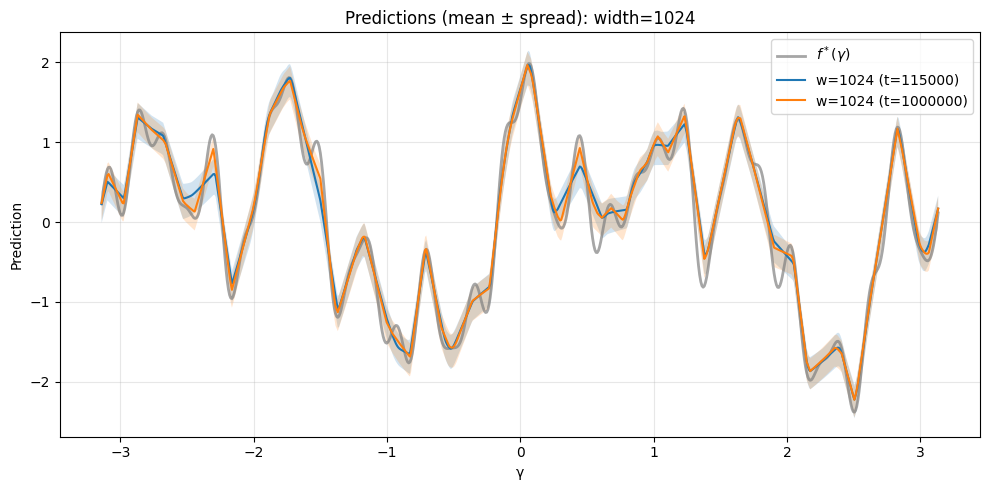


=== width=2048, freeze_step=310000 ===


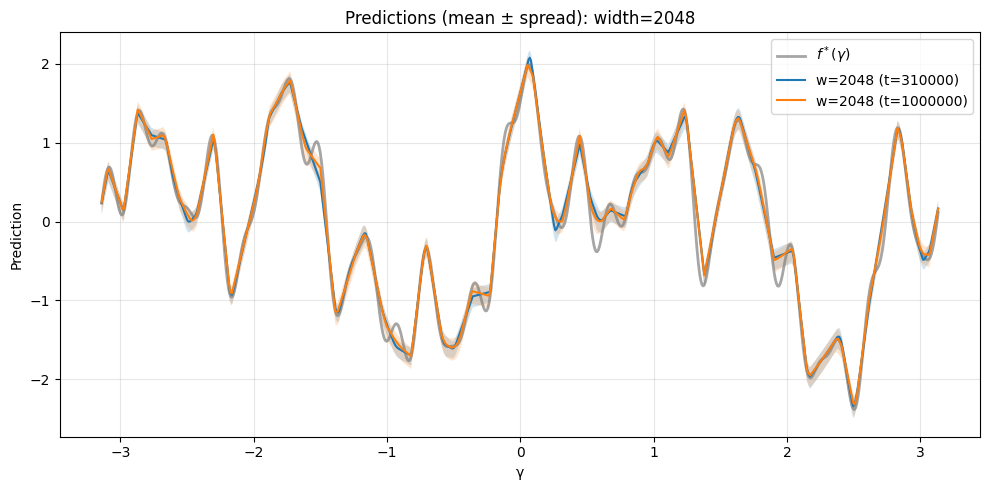

In [54]:
plot_all_freeze_vs_final_spread(RUN, man, freeze_steps)


=== width=1024, KR step=115000 ===


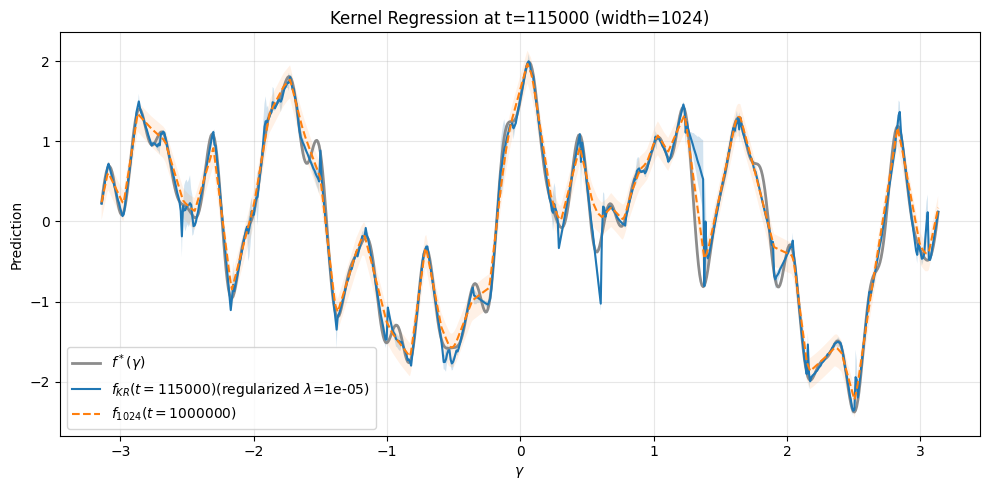


=== width=2048, KR step=310000 ===


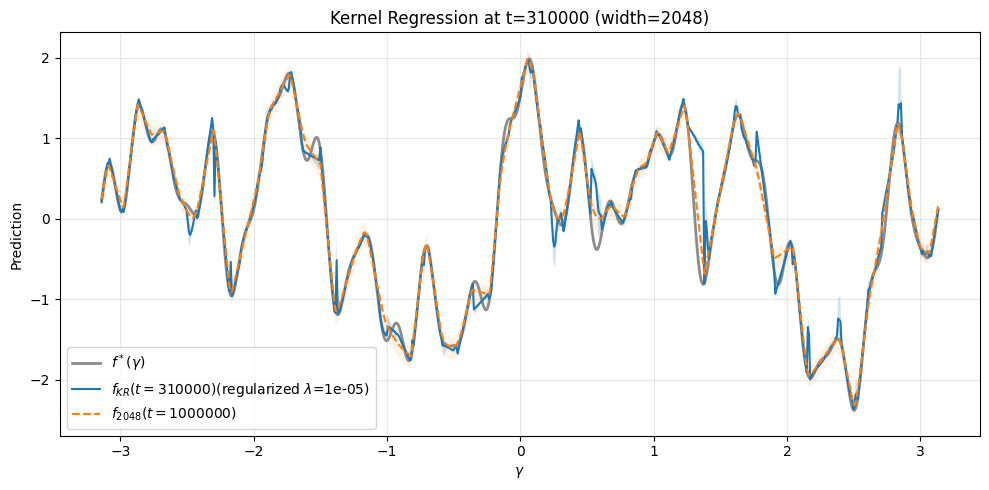

Skipping width 10000: no kr_step


In [57]:
plot_kernel_regression_all(RUN, man, freeze_steps, reg=1e-5)

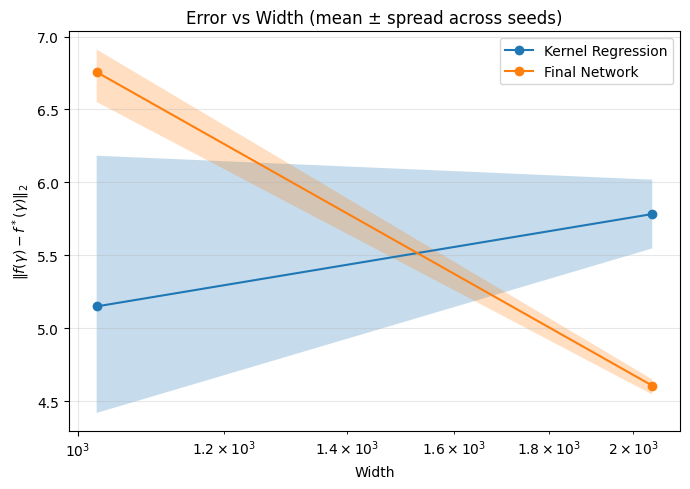

In [58]:
plot_error_vs_width(RUN, man, freeze_steps, reg=1e-5)

In [13]:
def collect_error_vs_width(run_dir, man, freeze_dict, 
                           widths_subset, reg=1e-3, 
                           q_low=10, q_high=90):
    """
    Collect mean + percentile error for:
        - f_KR(t_freeze)
        - f_net(t_freeze)
        - f_net(t_final)
    """

    data_block = npz(run_dir, man["data_file"])
    y_eval_true = data_block["y_eval_true"]

    widths = []

    kr_mean = [];      kr_lo = [];      kr_hi = []
    nnf_mean = [];     nnf_lo = [];     nnf_hi = []     # f_net(freeze)
    nnfinal_mean = []; nnfinal_lo = []; nnfinal_hi = [] # f_net(final)

    for width in widths_subset:

        freeze_step = freeze_dict.get(width, None)
        if freeze_step is None:
            continue

        block = npz(run_dir, man["runs"][str(width)])
        y_train = block["y_train"]

        # -------------------------
        # f_KR(t_freeze)
        # -------------------------
        seeds, Ktts, Kets = get_kernel_matrices_for_step(block, freeze_step)
        kr_preds = np.array([
            kernel_regression(Ktt, Ket, y_train, reg)
            for Ktt, Ket in zip(Ktts, Kets)
        ])

        # -------------------------
        # f_net(t_freeze)
        # -------------------------
        _, net_freeze_preds = get_preds_for_step(block, freeze_step)
        net_freeze_preds = np.array(net_freeze_preds)

        # -------------------------
        # f_net(t_final)
        # -------------------------
        final_step = int(np.max(block["preds_meta"][:,1]))
        _, net_final_preds = get_preds_for_step(block, final_step)
        net_final_preds = np.array(net_final_preds)

        # -------------------------
        # Errors (L2 across eval points)
        # -------------------------
        err_kr        = np.linalg.norm(kr_preds - y_eval_true, axis=1)
        err_net_freeze = np.linalg.norm(net_freeze_preds - y_eval_true, axis=1)
        err_net_final  = np.linalg.norm(net_final_preds - y_eval_true, axis=1)

        widths.append(width)

        # aggregate with percentiles
        kr_mean.append(err_kr.mean())
        kr_lo.append(np.percentile(err_kr, q_low))
        kr_hi.append(np.percentile(err_kr, q_high))

        nnf_mean.append(err_net_freeze.mean())
        nnf_lo.append(np.percentile(err_net_freeze, q_low))
        nnf_hi.append(np.percentile(err_net_freeze, q_high))

        nnfinal_mean.append(err_net_final.mean())
        nnfinal_lo.append(np.percentile(err_net_final, q_low))
        nnfinal_hi.append(np.percentile(err_net_final, q_high))

    return {
        "widths": np.array(widths),
        "kr_mean": np.array(kr_mean),
        "kr_lo":   np.array(kr_lo),
        "kr_hi":   np.array(kr_hi),
        "nnf_mean": np.array(nnf_mean),
        "nnf_lo":   np.array(nnf_lo),
        "nnf_hi":   np.array(nnf_hi),
        "nnfinal_mean": np.array(nnfinal_mean),
        "nnfinal_lo":   np.array(nnfinal_lo),
        "nnfinal_hi":   np.array(nnfinal_hi),
    }


def plot_error_vs_width_multi(run_data_dict, save_path=None, reg=1e-6):
    """
    Plot error vs width using:
        - f_KR(t_freeze)
        - f_net(t_freeze)
        - f_net(t_final)
    from multiple runs.
    """

    all_widths = []
    kr_mean = []; kr_lo = []; kr_hi = []
    nnf_mean = []; nnf_lo = []; nnf_hi = []
    nnfinal_mean = []; nnfinal_lo = []; nnfinal_hi = []

    # -------------------------
    #  Collect from all runs
    # -------------------------
    for _, (run_dir, man, freeze_dict, widths_subset) in run_data_dict.items():

        data = collect_error_vs_width(run_dir, man, freeze_dict, widths_subset, reg=reg)

        all_widths.extend(data["widths"])
        kr_mean.extend(data["kr_mean"])
        kr_lo.extend(data["kr_lo"])
        kr_hi.extend(data["kr_hi"])

        nnf_mean.extend(data["nnf_mean"])
        nnf_lo.extend(data["nnf_lo"])
        nnf_hi.extend(data["nnf_hi"])

        nnfinal_mean.extend(data["nnfinal_mean"])
        nnfinal_lo.extend(data["nnfinal_lo"])
        nnfinal_hi.extend(data["nnfinal_hi"])

    # -------------------------
    # Convert + sort
    # -------------------------
    widths = np.array(all_widths)
    idx = np.argsort(widths)
    widths = widths[idx]

    kr_mean = np.array(kr_mean)[idx]
    kr_lo   = np.array(kr_lo)[idx]
    kr_hi   = np.array(kr_hi)[idx]

    nnf_mean = np.array(nnf_mean)[idx]
    nnf_lo   = np.array(nnf_lo)[idx]
    nnf_hi   = np.array(nnf_hi)[idx]

    nnfinal_mean = np.array(nnfinal_mean)[idx]
    nnfinal_lo   = np.array(nnfinal_lo)[idx]
    nnfinal_hi   = np.array(nnfinal_hi)[idx]

    # -------------------------
    # Error bars
    # -------------------------
    kr_err = [kr_mean - kr_lo, kr_hi - kr_mean]
    nnf_err = [nnf_mean - nnf_lo, nnf_hi - nnf_mean]
    nnfinal_err = [nnfinal_mean - nnfinal_lo, nnfinal_hi - nnfinal_mean]

    # -------------------------
    # Plotting
    # -------------------------
    plt.figure(figsize=(8, 5))

    plt.errorbar(widths, kr_mean, yerr=kr_err,
                 fmt="o-", capsize=5,
                 label=r"$f_{\mathrm{KR}}(t_{\text{freeze}})$")

    plt.errorbar(widths, nnf_mean, yerr=nnf_err,
                 fmt="s--", capsize=5,
                 label=r"$f_{\text{net}}(t_{\text{freeze}})$")

    plt.errorbar(widths, nnfinal_mean, yerr=nnfinal_err,
                 fmt="d--", capsize=5,
                 label=r"$f_{\text{net}}(t_{\text{final}})$")

    plt.xticks(widths, [str(w) for w in widths])
    plt.xlabel("Width")
    plt.ylabel(r"$\|f(\gamma) - f^*(\gamma)\|_2$")
    plt.title("Error vs Width for $f_{\mathrm{KR}}$, $f_{\text{net}}(freeze)$, $f_{\text{net}}(final)$")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()


In [14]:
BASE = "../results"; EXP = "ntk_kernel_drift"
RUN_1 = latest_run_dir(BASE, EXP)

man_1 = load_manifest(RUN_1)

BASE = "../results"; EXP = "ntk_kernel_drift_large_widths"
RUN_2 = latest_run_dir(BASE, EXP)   

man_2 = load_manifest(RUN_2)

BASE = "../results"; EXP = "ntk_kernel_drift_10000_more_steps"
RUN_3 = latest_run_dir(BASE, EXP)

man_3 = load_manifest(RUN_3)

In [ ]:
widths_1 = [100, 512]
widths_2 = [1024, 2048, 10000]
widths_3 = [10000]

freeze_steps = {}
for width in widths_1:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN_1, man_1, width, normalize=True)
    freeze_step = find_freeze_step_plateau(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step

for width in widths_2:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN_2, man_2, width, normalize=True)
    freeze_step = find_freeze_step_plateau(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step

for width in widths_3:
    steps, d_mean, d_lo, d_hi = kernel_drift_over_seeds(RUN_3, man_3, width, normalize=True)
    freeze_step = find_freeze_step_plateau(steps, d_mean)

    print(f"Width {width} freeze step:", freeze_step)
    freeze_steps[width] = freeze_step
print(freeze_steps)



Width 100 freeze step: 13000
Width 512 freeze step: 51500
Width 1024 freeze step: 115000
Width 2048 freeze step: 310000
Width 10000 freeze step: None
Width 10000 freeze step: None
{100: 13000, 512: 51500, 1024: 115000, 2048: 310000, 10000: None}


In [16]:
import os
from pathlib import Path

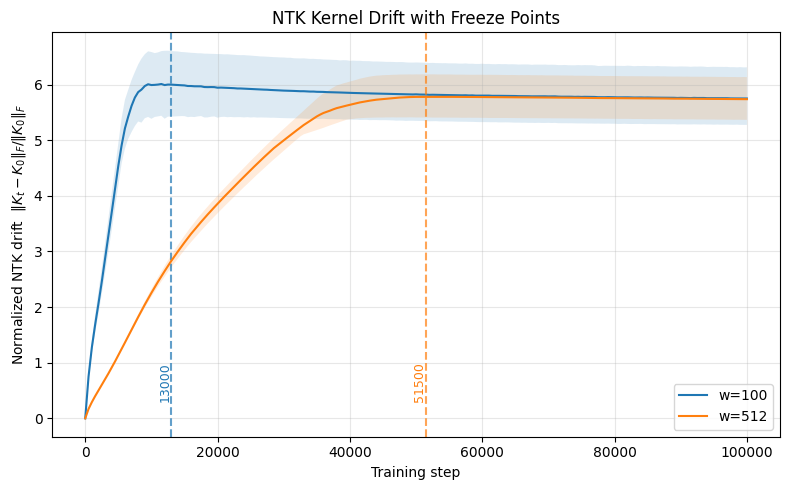

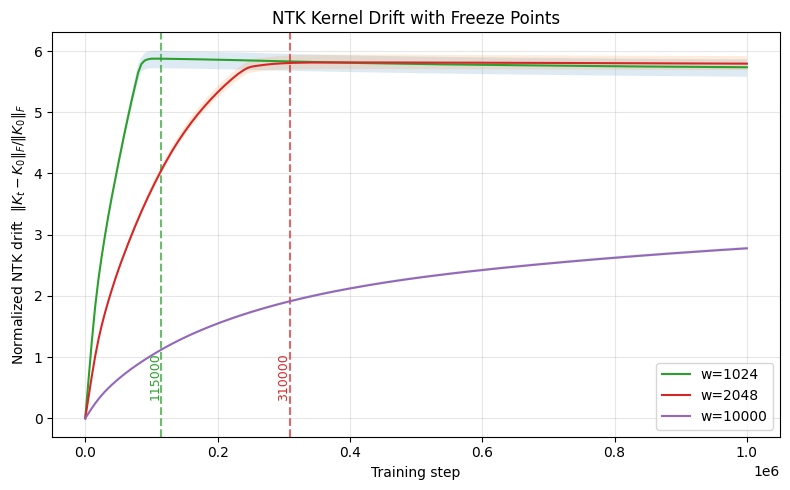

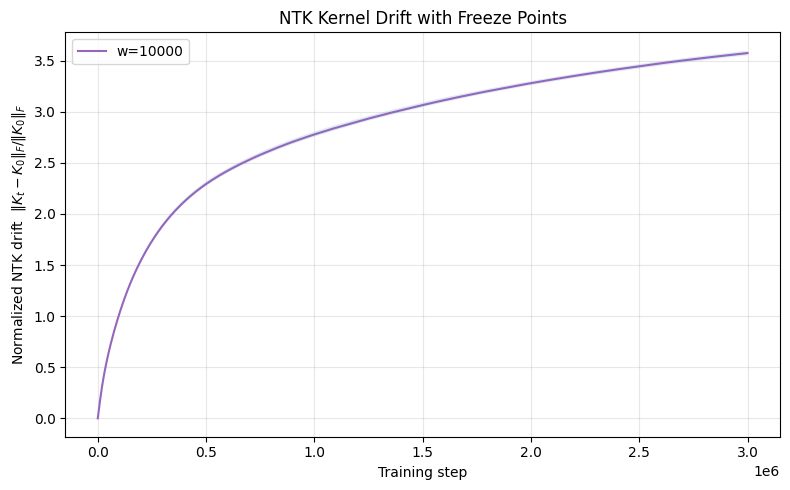

In [17]:
base_path = Path("plots") / "kernel_drift"
os.makedirs(base_path, exist_ok=True)
plot_kernel_drift_for_width(RUN_1, man_1, widths_1, save_path=base_path / "kernel_drift_low_widths.png")
plot_kernel_drift_for_width(RUN_2, man_2, widths_2, save_path=base_path / "kernel_drift_mid_widths.png")
plot_kernel_drift_for_width(RUN_3, man_3, widths_3, save_path=base_path / "kernel_drift_high_widths.png")

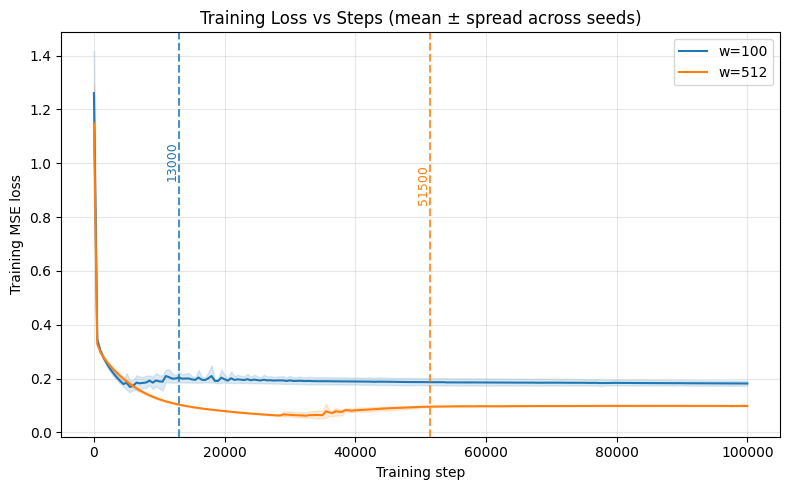

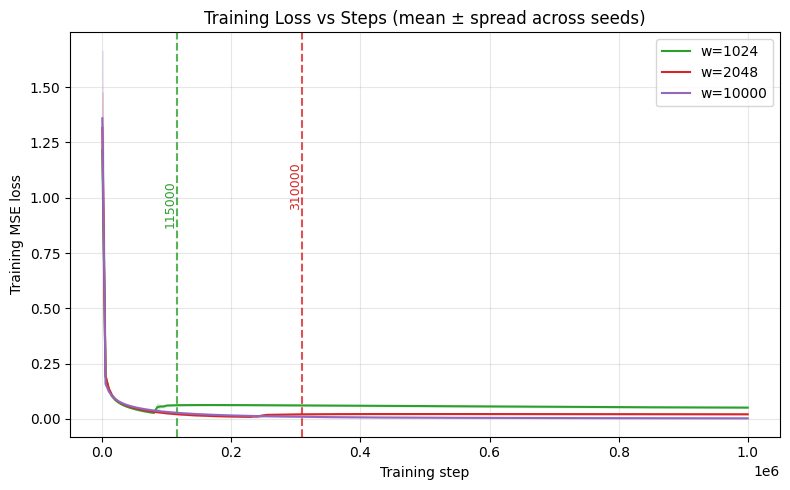

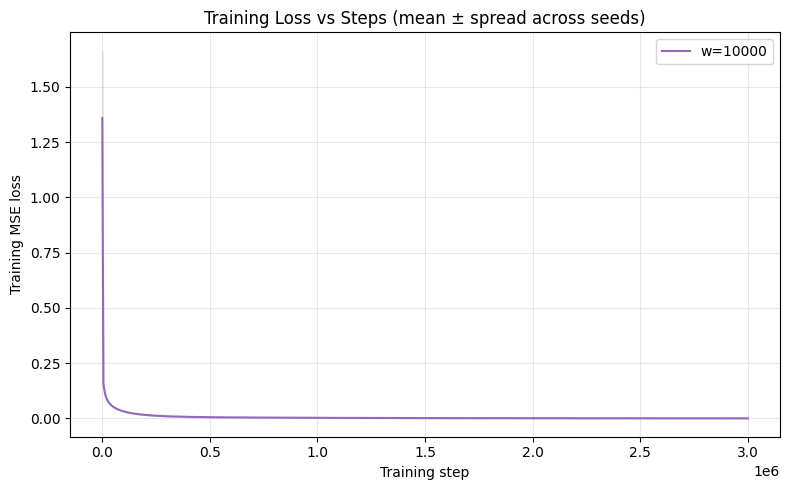

In [18]:
base_path = Path("plots") / "loss_curves"
os.makedirs(base_path, exist_ok=True)

plot_loss_for_widths(RUN_1, man_1, widths_1, freeze_dict=freeze_steps, save_path=base_path / "loss_low_widths.png")
plot_loss_for_widths(RUN_2, man_2, widths_2, freeze_dict=freeze_steps, save_path=base_path / "loss_mid_widths.png")
plot_loss_for_widths(RUN_3, man_3, widths_3, freeze_dict=freeze_steps, save_path=base_path / "loss_high_widths.png")


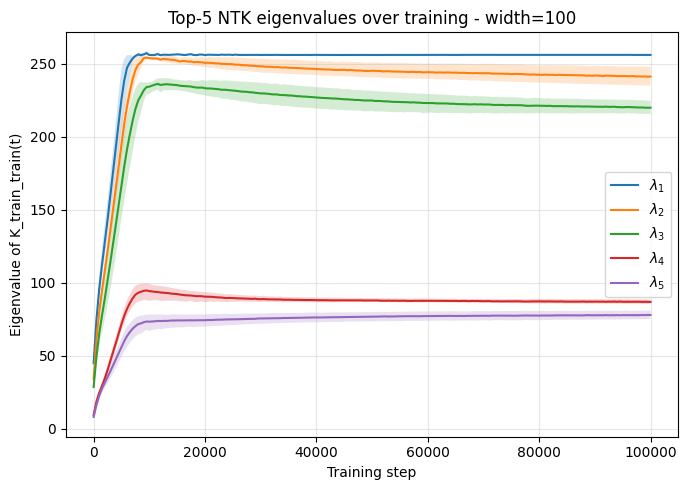

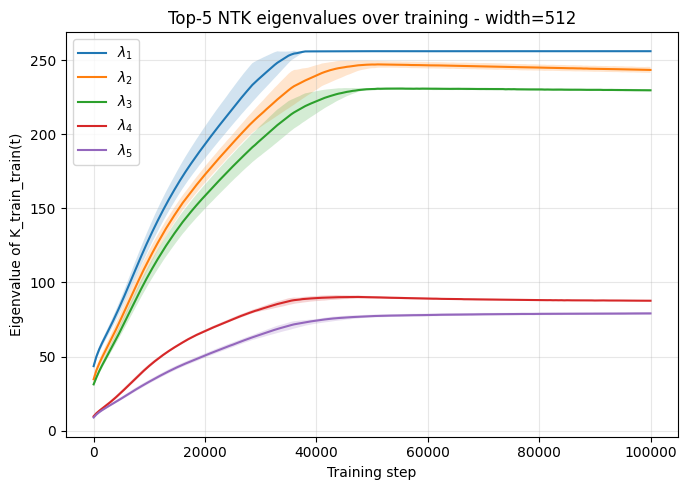

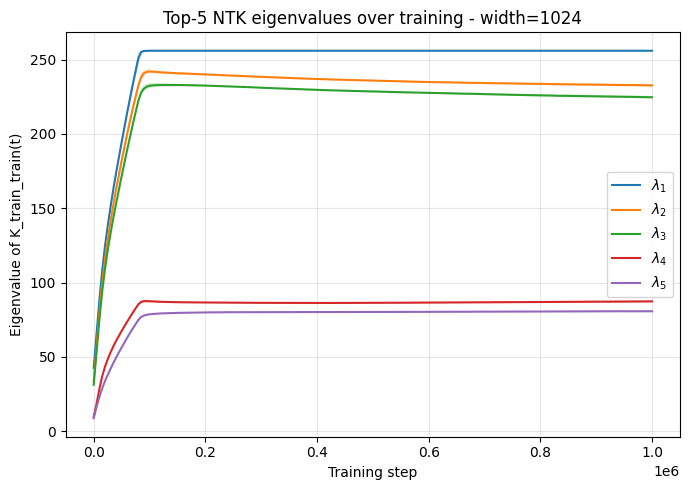

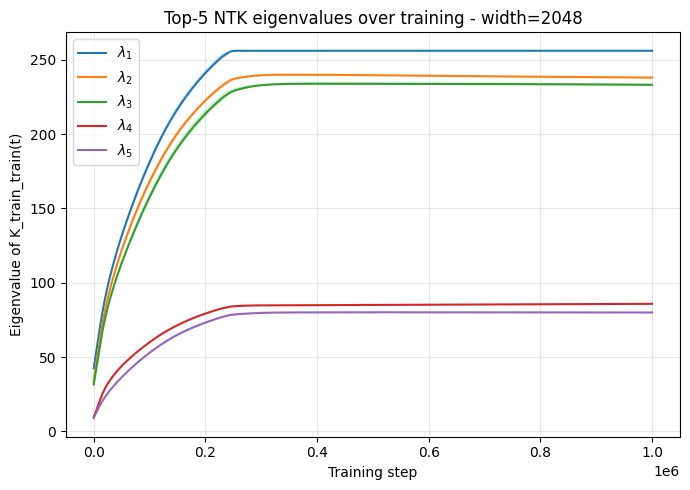

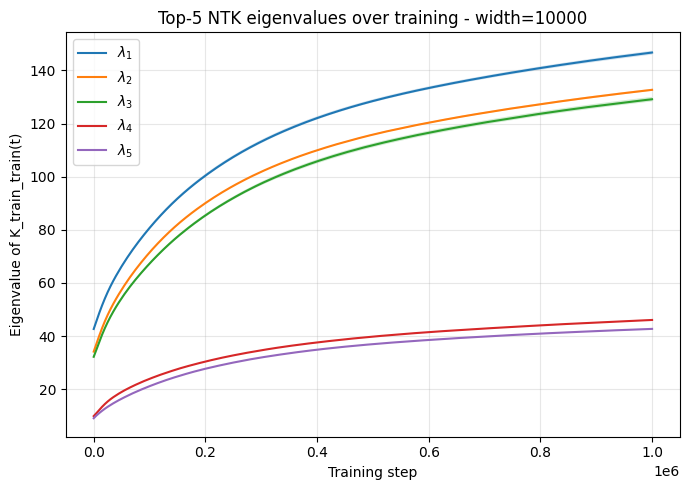

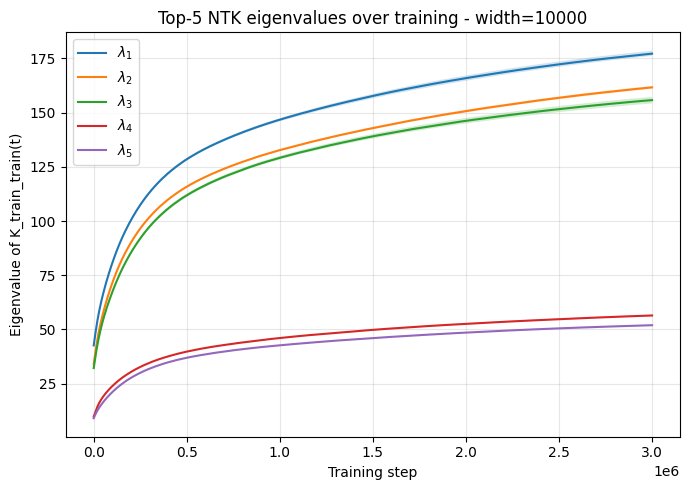

In [19]:
base_path = Path("plots") / "eigenvalues"
os.makedirs(base_path, exist_ok=True)

for width in widths_1:
    plot_topk_eigenvalues_for_width(RUN_1, man_1, width, k=5, save_path=base_path / f"eigenvalues_w{width}.png")

for width in widths_2:
    plot_topk_eigenvalues_for_width(RUN_2, man_2, width, k=5, save_path=base_path / f"eigenvalues_w{width}.png")

for width in widths_3:
    plot_topk_eigenvalues_for_width(RUN_3, man_3, width, k=5, save_path=base_path / f"eigenvalues_w{width}.png")


=== width=100, freeze_step=13000 ===


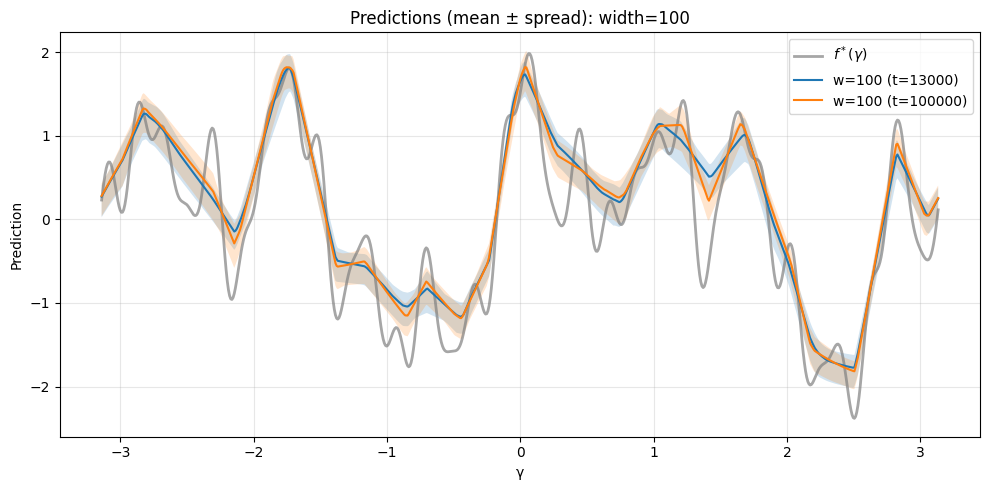


=== width=512, freeze_step=51500 ===


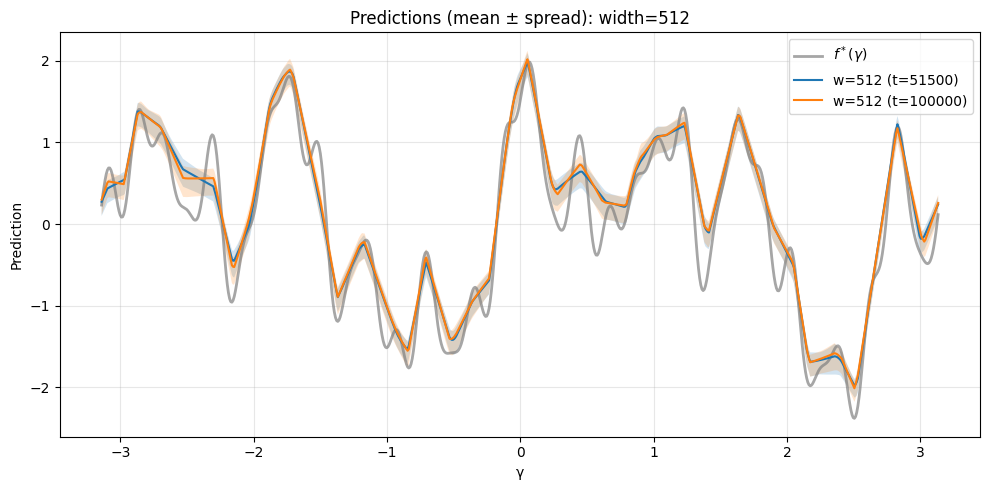


=== width=1024, freeze_step=115000 ===


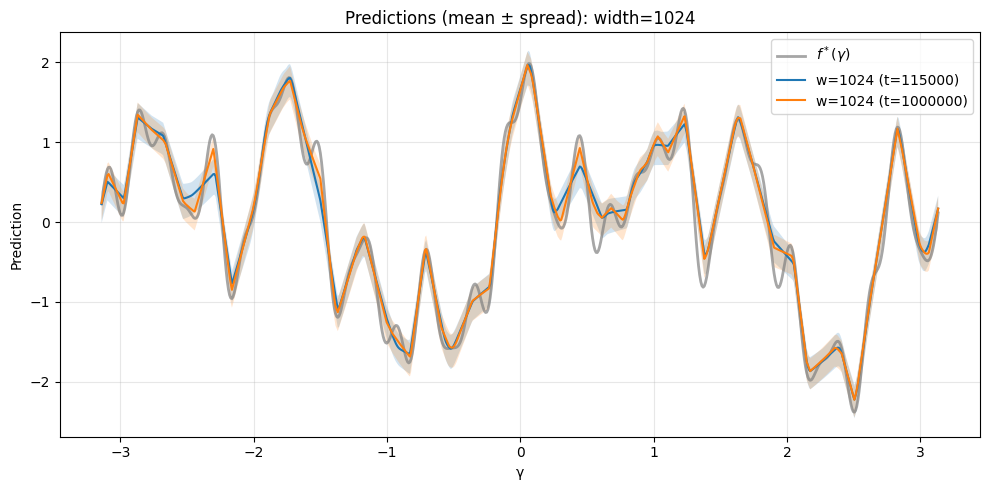


=== width=2048, freeze_step=310000 ===


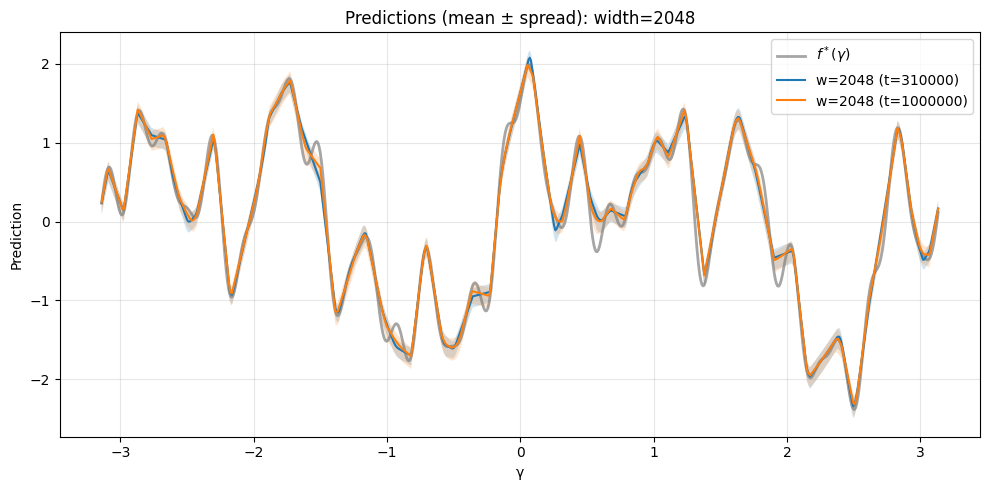

In [20]:
base_path = Path("plots") / "freeze_vs_final_spread"
os.makedirs(base_path, exist_ok=True)

plot_all_freeze_vs_final_spread(RUN_1, man_1, freeze_steps, widths=widths_1, save_path=base_path / "freeze_vs_final_low_widths.png")
plot_all_freeze_vs_final_spread(RUN_2, man_2, freeze_steps, widths=widths_2, save_path=base_path / "freeze_vs_final_mid_widths.png")
plot_all_freeze_vs_final_spread(RUN_3, man_3, freeze_steps, widths=widths_3, save_path=base_path / "freeze_vs_final_high_widths.png")


=== width=100, KR step=13000 ===


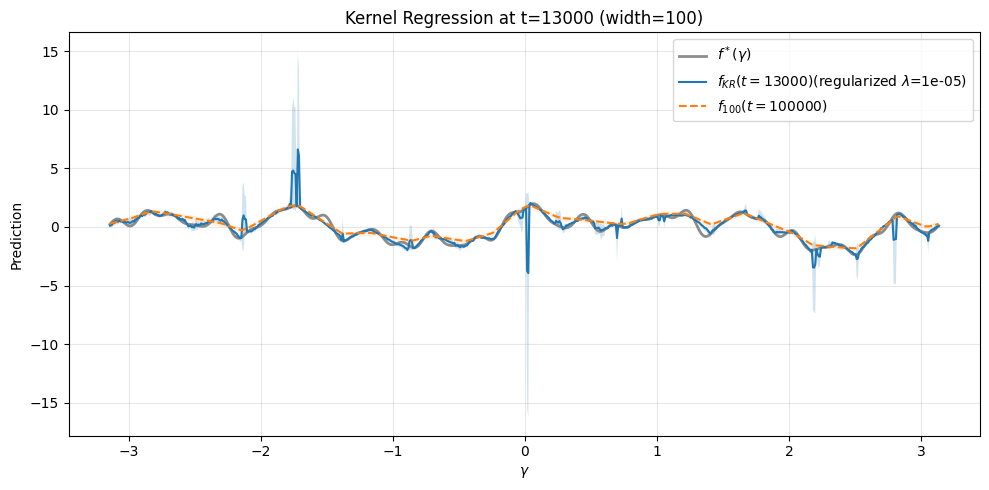


=== width=512, KR step=51500 ===


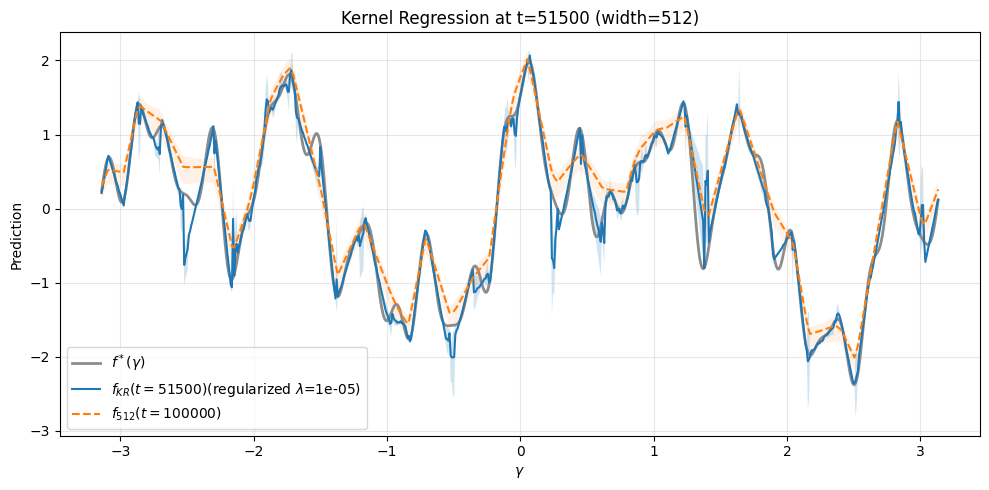


=== width=1024, KR step=115000 ===


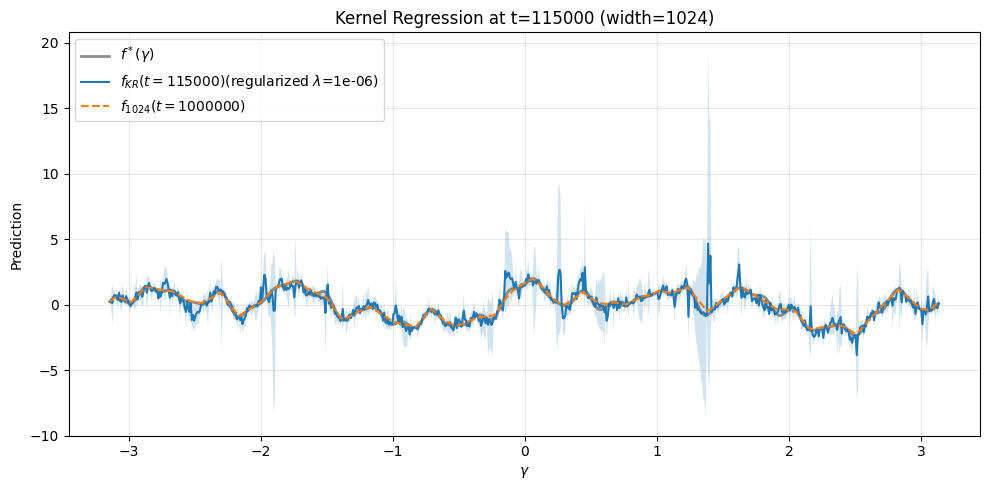


=== width=2048, KR step=310000 ===


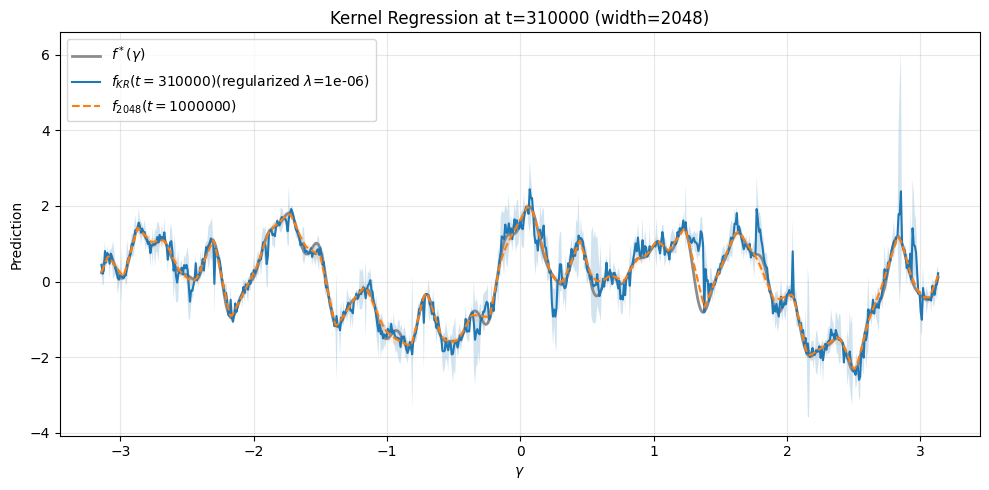

Skipping width 10000: no kr_step
Skipping width 10000: no kr_step


In [29]:
base_path = Path("plots") / "kernel_regression"
os.makedirs(base_path, exist_ok=True)

plot_kernel_regression_all(RUN_1, man_1, {w: freeze_steps[w] for w in widths_1}, reg=1e-5, save_path=base_path / "kernel_regression_low_widths.png")
plot_kernel_regression_all(RUN_2, man_2, {w: freeze_steps[w] for w in widths_2}, reg=1e-6, save_path=base_path / "kernel_regression_mid_widths.png")
plot_kernel_regression_all(RUN_3, man_3, {w: freeze_steps[w] for w in widths_3}, reg=1e-5, save_path=base_path / "kernel_regression_high_widths.png")

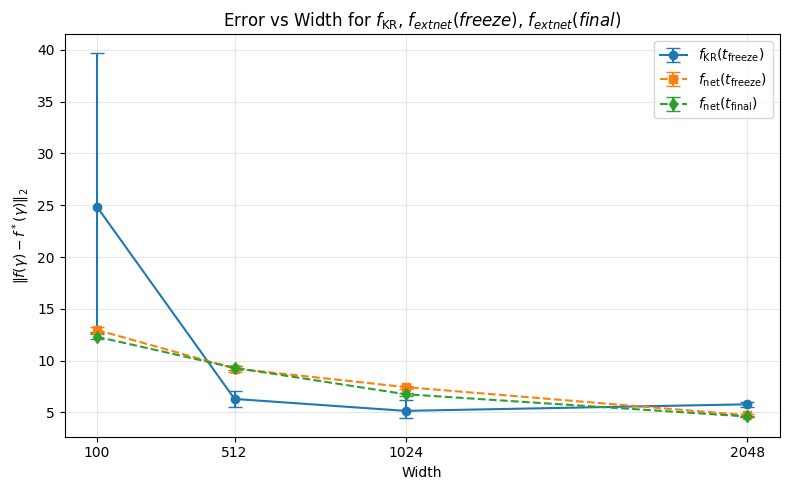

In [37]:
run_data_dict = {
    "run_1": (
        RUN_1,
        man_1,
        freeze_steps,
        widths_1   
    ),
    "run_2": (
        RUN_2,
        man_2,
        freeze_steps,
        widths_2,
    ),
    "run_3": (
        RUN_3,
        man_3,
        freeze_steps,
        widths_3,
    )
}

plot_error_vs_width_multi(run_data_dict, save_path=Path("plots") / "error_vs_width_combined.png", reg=1e-5)


# Fourier analysis on empirical NTKs

In [37]:
BASE = "../results"; EXP = "ntk_kernel_drift"
RUN = latest_run_dir(BASE, EXP)

In [38]:
man = load_manifest(RUN)
man

{'data_file': 'data_fourier.npz',
 'runs': {'100': 'runs/width_100.npz',
  '512': 'runs/width_512.npz',
  '1024': 'runs/width_1024.npz',
  '2048': 'runs/width_2048.npz',
  '10000': 'runs/width_10000.npz'},
 'meta': {'widths': [100, 512, 1024, 2048, 10000],
  'seeds': 5,
  'steps': 100000,
  'lr': 1.0,
  'eval_every': 500,
  'depth_hidden': 1,
  'M_train': 256,
  'n_eval': 720,
  'noise_std': 0.02},
 'runtime_sec': 1588.06}

In [39]:
data = npz(RUN, man["data_file"])
data.keys()

dict_keys(['gamma_eval', 'X_eval', 'y_eval_true', 'gamma_train', 'X_train', 'y_train', 'Ks', 'amps', 'phases'])

In [40]:
X_train = data["X_train"]
y_train = data["y_train"]
gamma_train = data["gamma_train"]
gamma_eval = data["gamma_eval"]

mask = np.isin(gamma_eval, gamma_train)
train_indices_in_eval = np.where(mask)[0]

print(f"{X_train.shape=}, {y_train.shape=}, {gamma_train.shape=}")
print(train_indices_in_eval)

X_train.shape=(256, 2), y_train.shape=(256,), gamma_train.shape=(256,)
[  0   1   4   5   6   8  12  13  16  18  19  20  24  25  30  31  34  35
  36  37  38  39  40  41  43  45  51  53  55  56  58  67  70  80  82  84
  86  88  90  96  98 102 104 109 110 112 114 119 120 124 125 130 132 136
 144 145 146 150 152 157 162 165 166 169 172 177 178 180 188 194 197 200
 201 203 204 207 209 210 217 218 219 221 226 228 234 235 239 245 250 259
 263 264 265 266 268 269 270 272 274 275 276 278 279 280 283 285 287 288
 291 292 299 305 308 309 310 311 312 317 318 319 327 333 334 336 339 340
 342 351 353 359 360 364 365 366 371 376 385 386 392 396 400 403 405 411
 413 415 416 418 419 420 430 433 435 436 438 441 442 445 449 451 452 453
 456 463 466 469 470 472 473 474 475 478 479 482 484 485 486 487 488 489
 491 493 495 498 501 503 504 518 522 526 528 529 530 531 537 538 539 543
 547 549 553 555 556 559 562 573 576 578 586 590 591 593 595 596 598 600
 604 606 609 613 617 621 622 630 636 637 639 640 646 

In [41]:
block = npz(RUN, man["runs"]["100"])
block.keys()

dict_keys(['K_train_train', 'K_eval_train', 'kernel_meta', 'preds', 'preds_meta', 'loss_meta', 'loss_values', 'X_train', 'y_train'])

In [42]:
seeds, Ktts, Kets = get_kernel_matrices_for_step(block, 1000)
print(f"{len(Ktts)=},{Ktts[0].shape=}")

len(Ktts)=5,Ktts[0].shape=(256, 256)


In [43]:
def mode_decay_over_time(run_dir, man, width, num_modes=5,
                         q_low=10, q_high=90):
    """
    For a given width, compute mode coefficients c_i(t) over time.
    
    Returns:
        steps_unique : (T_steps,)
        c_mean       : (T_steps, num_modes)
        c_lo         : (T_steps, num_modes)
        c_hi         : (T_steps, num_modes)
    """
    block = npz(run_dir, man["runs"][str(width)])
    preds = block["preds"]                 # (T_snap, N_train)
    preds_meta = block["preds_meta"]       # (T_snap, 2): (seed, step)

    K_all = block["K_train_train"]         # (T_snap, N_train, N_train)
    K_meta = block["kernel_meta"]          # (T_snap, 2): (seed, step)

    # training targets
    data = npz(run_dir, man["data_file"])
    gamma_train = data["gamma_train"]              # (N_train,)
    gamma_eval = data["gamma_eval"]
    y_train = data["y_train"]              # (N_train,)
    mask = np.isin(gamma_eval, gamma_train)
    train_indices_in_eval = np.where(mask)[0]

    steps_unique = np.sort(np.unique(K_meta[:, 1]))

    # outputs
    c_mean = []
    c_lo   = []
    c_hi   = []

    for step in steps_unique:
        # collect all seeds for this step
        mask_pred = (preds_meta[:, 1] == step)
        mask_K    = (K_meta[:, 1] == step)

        preds_step = preds[mask_pred]      # shape (n_seeds, N_train)
        K_step     = K_all[mask_K]         # shape (n_seeds, N_train, N_train)

        c_modes_seed = []  # list of (num_modes,) per seed

        # for each seed, compute projection c_i(t)
        for f_pred, Ktt in zip(preds_step, K_step):
            f_pred_train = f_pred[train_indices_in_eval]
            r = f_pred_train - y_train  # residual on train set

            # eigen-decomp (symmetric)
            evals, evecs = np.linalg.eigh(Ktt.squeeze())

            # sort descending
            idx = np.argsort(evals)[::-1]
            evals = evals[idx]
            evecs = evecs[:, idx]

            # top-k eigenvectors
            U_top = evecs[:, :num_modes]  # (N_train, num_modes)

            # projections c_i = u_i^T r
            c = U_top.T @ r               # (num_modes,)
            c_modes_seed.append(np.abs(c)) # take magnitude

        c_modes_seed = np.array(c_modes_seed)  # (n_seeds, num_modes)

        c_mean.append(c_modes_seed.mean(axis=0))
        lo, hi = np.percentile(c_modes_seed, [q_low, q_high], axis=0)
        c_lo.append(lo)
        c_hi.append(hi)

    return (
        steps_unique,
        np.array(c_mean),
        np.array(c_lo),
        np.array(c_hi)
    )


def plot_mode_decay_over_time(run_dir, man, width,
                              num_modes=5, q_low=10, q_high=90,
                              freeze_step=None, save_path=None):

    steps, c_mean, c_lo, c_hi = mode_decay_over_time(
        run_dir, man, width, num_modes=num_modes,
        q_low=q_low, q_high=q_high
    )

    plt.figure(figsize=(8, 5))

    for i in range(num_modes):
        plt.plot(steps, c_mean[:, i], label=rf"|c$_{i+1}$(t)|")
        plt.fill_between(steps, c_lo[:, i], c_hi[:, i], alpha=0.2)

    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Residual mode amplitude  |c_i(t)|")
    plt.title(f"Decay of top {num_modes} NTK modes (width={width})")

    # --- Add freeze-step vertical line ---
    if freeze_step is not None:
        plt.axvline(freeze_step, color="red", linestyle="--",
                    linewidth=2, alpha=0.8,
                    label=f"NTK freeze step = {freeze_step}")

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()


In [44]:
freeze_steps = {
    100: FREEZE_INC["low"][100],
    512: FREEZE_INC["low"][512],
    1024: FREEZE_INC["mid"][1024],
    2048: FREEZE_INC["mid"][2048],
    10000: FREEZE_INC["high"][10000],
}

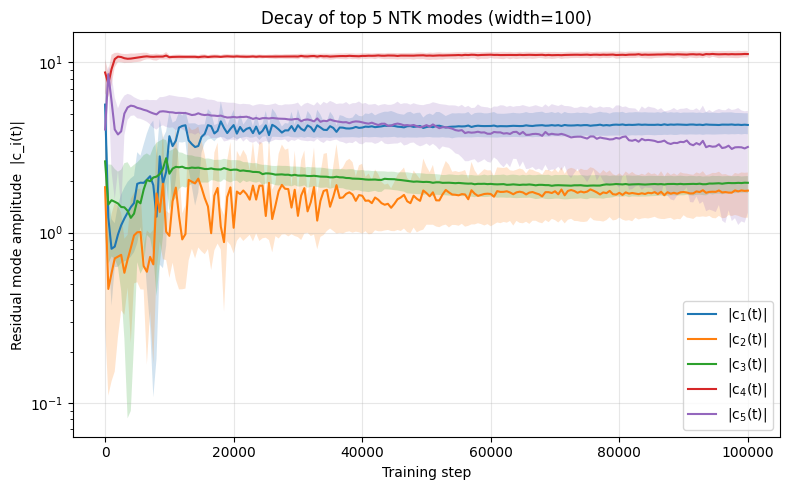

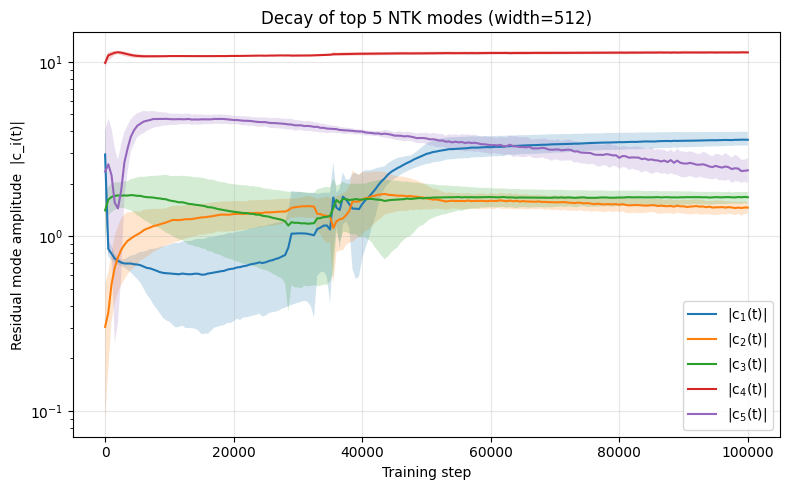

In [45]:
base_path = Path("plots") / "mode_decay"
os.makedirs(base_path, exist_ok=True)

BASE = "../results"; EXP = "ntk_kernel_drift"
RUN = latest_run_dir(BASE, EXP)
man = load_manifest(RUN)
plot_mode_decay_over_time(RUN, man, width=100, num_modes=5, freeze_step=freeze_steps[100], save_path=base_path / "mode_decay_w100.png")
plot_mode_decay_over_time(RUN, man, width=512, num_modes=5, freeze_step=freeze_steps[512], save_path=base_path / "mode_decay_w512.png")

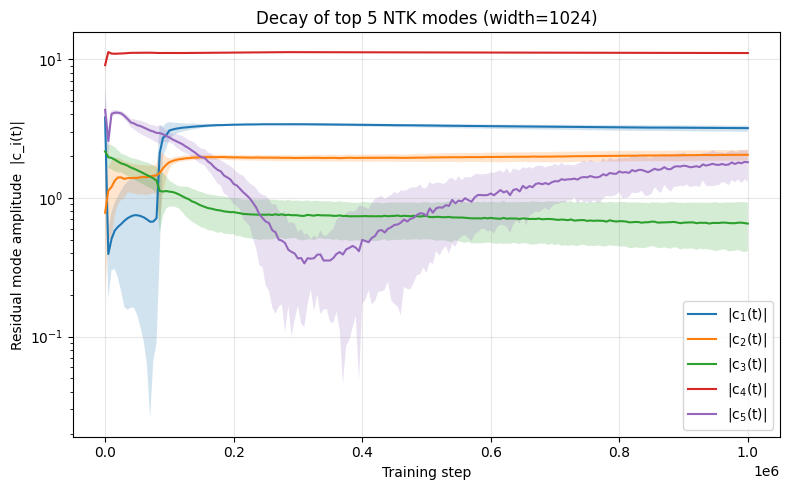

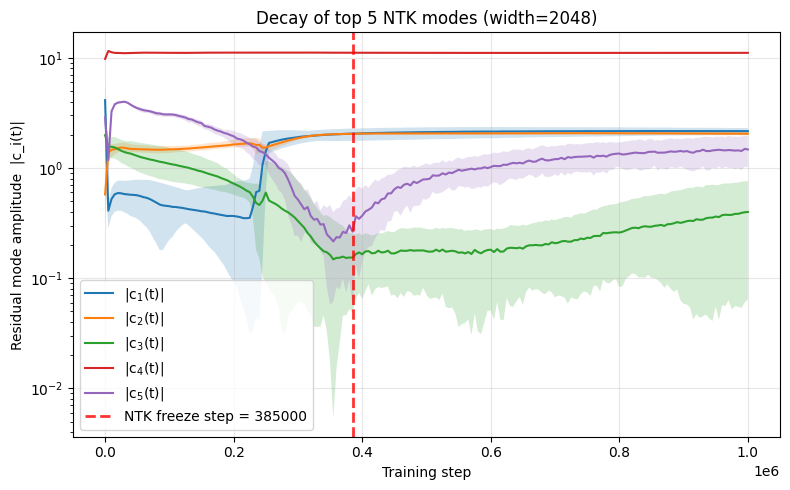

In [46]:
base_path = Path("plots") / "mode_decay"
os.makedirs(base_path, exist_ok=True)

BASE = "../results"; EXP = "ntk_kernel_drift_large_widths"
RUN = latest_run_dir(BASE, EXP)
man = load_manifest(RUN)
plot_mode_decay_over_time(RUN, man, width=1024, num_modes=5, freeze_step=freeze_steps[1024], save_path=base_path / "mode_decay_w1024.png")
plot_mode_decay_over_time(RUN, man, width=2048, num_modes=5, freeze_step=freeze_steps[2048], save_path=base_path / "mode_decay_w2048.png")

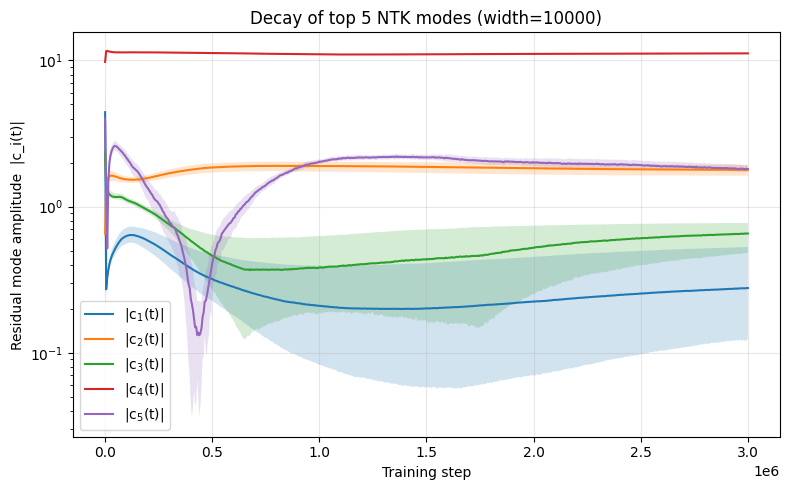

In [47]:
base_path = Path("plots") / "mode_decay"
os.makedirs(base_path, exist_ok=True)

BASE = "../results"; EXP = "ntk_kernel_drift_10000_more_steps"
RUN = latest_run_dir(BASE, EXP)
man= load_manifest(RUN)
plot_mode_decay_over_time(RUN, man, width=10000, num_modes=5, save_path=base_path / "mode_decay_w10000.png")

In [ ]:
def build_mixture_basis(gamma_eval, Ks, phases):
    """
    gamma_eval : (M,)
    Ks         : list/array of frequencies (len = J)
    phases     : list/array of phases (len = J)

    Returns:
        B : (M, J) where column j is b_j(γ) = sin(K_j γ + φ_j)
        norms_sq : (J,) with ⟨b_j, b_j⟩ (discrete)
    """
    gamma = np.asarray(gamma_eval)
    Ks = np.asarray(Ks)
    phases = np.asarray(phases)

    cols = []
    for K, phi in zip(Ks, phases):
        b = np.sin(K * gamma + phi)
        cols.append(b)

    B = np.stack(cols, axis=1)          # (M, J)
    norms_sq = np.sum(B * B, axis=0)    # ⟨b_j, b_j⟩ per column

    return B, norms_sq

In [ ]:
def mixture_basis_residual_over_time(run_dir, man, width,
                                     Ks, phases,
                                     q_low=10, q_high=90):
    """
    For given width, project residuals on eval circle onto the 7 mixture basis
    b_j(γ) = sin(K_j γ + φ_j) and track |coeff_j(t)| over time (mean ± spread).

    Returns:
        steps         : (T_steps,)
        coeff_mean    : (T_steps, J)
        coeff_lo      : (T_steps, J)
        coeff_hi      : (T_steps, J)
    """
    # Load eval geometry + target
    # data_probe = npz(run_dir, man["probe_geometry"])
    data = npz(run_dir, man["data_file"])
    gamma_eval = data["gamma_eval"]      # (M,)
    y_eval_true = data["y_eval_true"]    # (M,)

    # Basis from your 7 components (unscaled)
    B, norms_sq = build_mixture_basis(gamma_eval, Ks, phases)  # (M,J), (J,)

    block = npz(run_dir, man["runs"][str(width)])
    preds = block["preds"]          # (T_snap, M_eval)
    preds_meta = block["preds_meta"]  # (T_snap, 2): (seed, step)

    steps = np.sort(np.unique(preds_meta[:, 1]))
    J = len(Ks)

    coeff_mean = []
    coeff_lo   = []
    coeff_hi   = []

    for step in steps:
        mask = (preds_meta[:, 1] == step)
        preds_step = preds[mask]           # (n_seeds, M_eval)

        coeffs_seed = []

        for f_pred in preds_step:
            r = f_pred - y_eval_true       # residual on eval grid, (M,)

            # projections: c_j = ⟨r, b_j⟩ / ⟨b_j, b_j⟩
            numer = B.T @ r                # (J,)
            c = numer / norms_sq           # (J,)

            coeffs_seed.append(np.abs(c))  # magnitude along each basis vector

        coeffs_seed = np.asarray(coeffs_seed)  # (n_seeds, J)

        coeff_mean.append(coeffs_seed.mean(axis=0))
        lo, hi = np.percentile(coeffs_seed, [q_low, q_high], axis=0)
        coeff_lo.append(lo)
        coeff_hi.append(hi)

    return (
        steps,
        np.asarray(coeff_mean),  # (T_steps, J)
        np.asarray(coeff_lo),
        np.asarray(coeff_hi),
    )


In [ ]:
def plot_mixture_component_decay(run_dir, man, width,
                                 Ks, phases,
                                 q_low=10, q_high=90,
                                 freeze_step=None,
                                 save_path=None):
    steps, c_mean, c_lo, c_hi = mixture_basis_residual_over_time(
        run_dir, man, width, Ks, phases, q_low=q_low, q_high=q_high
    )

    J = len(Ks)
    plt.figure(figsize=(8, 5))

    for j in range(J):
        K = Ks[j]
        plt.plot(steps, c_mean[:, j], label=fr"k={K}")
        plt.fill_between(steps, c_lo[:, j], c_hi[:, j], alpha=0.2)

    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel(r"Residual amplitude along component $j$ ")
    plt.title(f"Decay of 7 mixture components (width={width})")
    plt.grid(alpha=0.3)

    if freeze_step is not None:
        plt.axvline(freeze_step, color="red", linestyle="--", linewidth=2,
                    alpha=0.8, label=f"freeze @ {freeze_step}")

    plt.legend(title="Fourier freq", fontsize=9)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
data = npz(RUN, man["data_file"])
data.keys()

dict_keys(['gamma_eval', 'X_eval', 'y_eval_true', 'gamma_train', 'X_train', 'y_train', 'Ks', 'amps', 'phases'])

In [ ]:
Ks = data["Ks"]
amps = data["amps"]
phases = data["phases"]

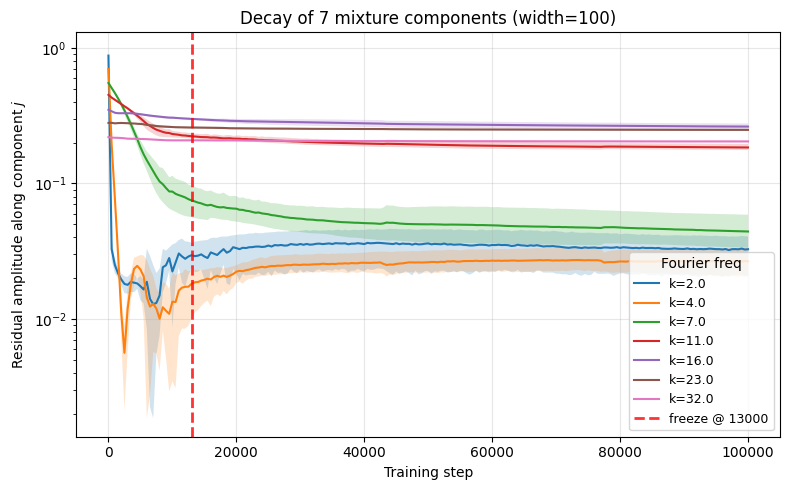

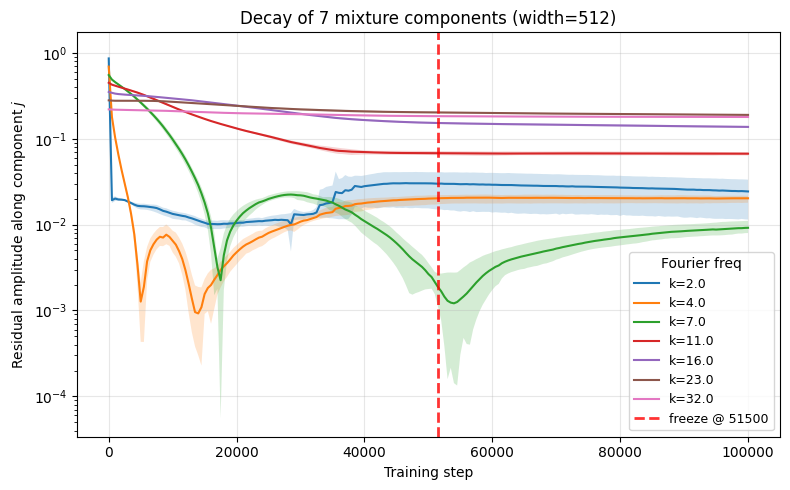

In [ ]:
base_path = Path("plots") / "fourier_decay"
os.makedirs(base_path, exist_ok=True)

BASE = "../results"; EXP = "ntk_kernel_drift"
RUN = latest_run_dir(BASE, EXP)
man = load_manifest(RUN)
for width in [100, 512]:
    plot_mixture_component_decay(RUN, man, width, Ks=Ks, phases=phases,
                                 freeze_step=freeze_steps[width], save_path=base_path / f"fourier_decay_w{width}.png")

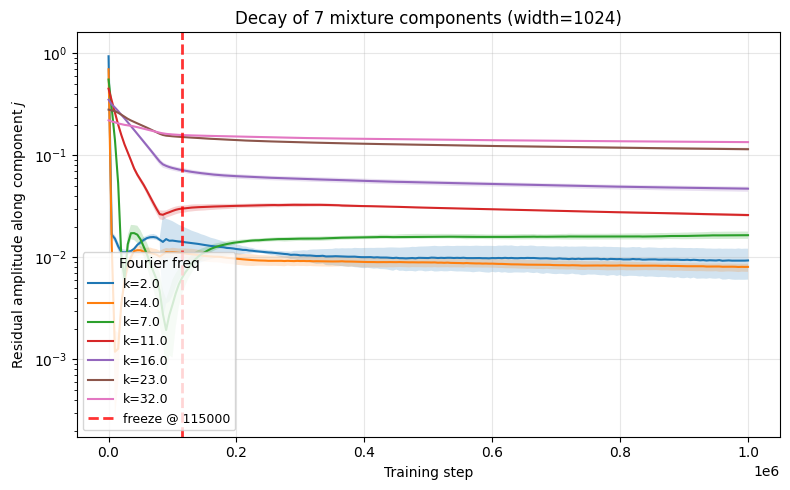

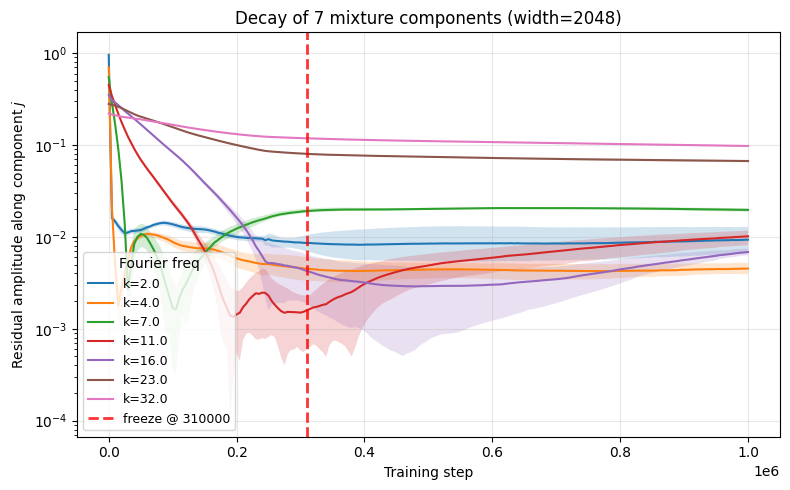

In [ ]:
BASE = "../results"; EXP = "ntk_kernel_drift_large_widths"
RUN = latest_run_dir(BASE, EXP)
man = load_manifest(RUN)
for width in [1024, 2048]:
    plot_mixture_component_decay(RUN, man, width, Ks=Ks, phases=phases,
                                 freeze_step=freeze_steps[width], save_path=base_path / f"fourier_decay_w{width}.png")

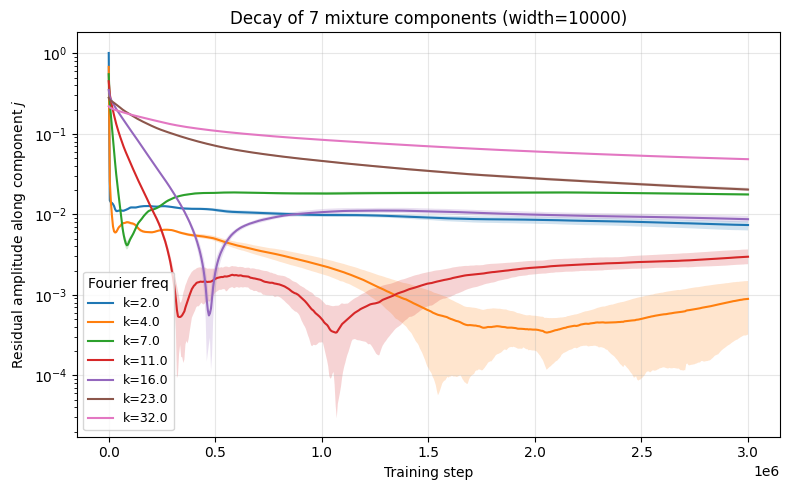

In [ ]:
BASE = "../results"; EXP = "ntk_kernel_drift_10000_more_steps"
RUN = latest_run_dir(BASE, EXP)
man= load_manifest(RUN)
for width in [10000]:
    plot_mixture_component_decay(RUN, man, width, Ks=Ks, phases=phases, save_path=base_path / f"fourier_decay_w{width}.png")